<a href="https://colab.research.google.com/github/edelauna/a-notebook-for-your-augury/blob/main/A_Notebook_for_your_Augury.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Notebook For Your Augury
By: Elliott de Launay

Template to make machine learning a bit easier to follow and repeatable.

Github: [A Notebook For Your Augury](https://github.com/edelauna/a-notebook-for-your-augury)

Will try out a build as we go kind of style.

How To Use:
* Best to go cell by cell
* Cell's are organized so that at the top there is some kind of `ALL_CAPS` variable which is either an array of Dicts or Dict, with the intent of passing this as input to the functions specified.
* After the config, code is marked betwen a block:
```
  # Some Config here
  """"
  """"
  # There will be some code here which is the mechanics of what's being performed
  # This code then dynamically added to the Augury class 
  #    (In hopes it makes it easier to follow along)
  """"
  """"
  # Then the actual code which runs the above function with the configs
```

Goal:
* Automate:
  * Transformations applied to Training Data, also get applied test.
  * Evaluate 3 Models
    * Included a 4th Model (KMeans) as _experiemental_
  * Select best performing model to be used for Test

In [55]:
# Dependancies
# If not installed restart Kernel
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [56]:
from datetime import datetime as dt
from inspect import getsource
### Initialization
class Augury:
  def method(*funcs):
    """
    Static 'Decorator' which adds funcs to this class    
    """
    for func in funcs:
      setattr(__class__, func.__name__, func)
  def _attr(self, *readers, overwrite=True, **writers):
    """
    Returns the relevent self.attr.
    Will also set a value if passed with a value.
      Parameters
      ----------
      readers : str
          attr to return
      overwrite : bool
          if False, will not set a value, if a value exists
      writers : Dict
          key as attr to return, value as value to set.
      Returns
      ----------
      tuple of ordered attrs
    """
    _attrs = []
    for attr in readers:
      _attrs.append(getattr(self,attr)) if hasattr(self, attr) else _attrs.append(None)
    for attr in writers:
      if not hasattr(self, attr) or overwrite:
        setattr(self, attr, writers[attr])
      _attrs.append(getattr(self,attr))
    return tuple(_attrs)
  def _hash(self, hash, *keys):
    """
    Helper function to destructure a hash.
    ...didn't end up using this as much
      Parameters
      ----------
      hash : Dictionary
          hash to destructure
      keys : str
          values at key will be returned.
      Returns
      ----------
      tuple of ordered hash values
    """
    results = []
    for key in keys:
      results.append(hash[key]) if key in hash else results.append(None)
    return tuple(results)
  def _latency(self, func, dt=dt):
    """
    Wraps a function to print latency of long running operations
    """
    def wrapper(*args, **kwargs):
      _start = dt.now()
      _result = func(*args, **kwargs)
      print("Latency (hh:mm:ss.ms):{}".format(dt.now()-_start))
      return _result
    return wrapper
  def _input_guard(self, condition, *args, getsource=getsource):
    """
    Returns a standardized assert.
      Parameters
      -------
      condition : callable function that should evaluate to true, when passed *args
    """
    assert condition(*args), "{} not true, when passed: {}.".format(getsource(condition), args)
# Setting up cache for some longer running functions
import os
AUGURY_CACHE=".augury/.cache"
os.environ["AUGURY_CACHE"]=AUGURY_CACHE
%mkdir -p $AUGURY_CACHE

# Setting main variable to hold it all
augur = Augury()

## Pipeline
The goal of this notebook is to provide a template for machine learning modelling when working with "simple" Continous and Categorical data. The notebook will perform the following:
1. Read in Data
2. Explore Data
    1. Set Label
    1. Categorical Features
        1. Handle Nulls
        2. Feature Engineering
    3. Continous Features
        1. Handle Nulls
        1. Cap and Floor Outliers
        2. Feature Engineering
1. Transform
  1. Transform Skewed Features
  2. Transform to Numerical Indicators
  1. Feature Scaling & Optimal Count
2. Principal Component Analysis
1. Train / Validation Split
3. Model Selection
    1. Hyperparameter Tuning
    1. Fit
    1. Evaluation
4. Test


## Read in Data
This notebook is prioritized to run in Google Colab, so incorporates mounting a Google Drive, and then connecting to Kaggle.

In [57]:
"""
Comment out the following blocks to integrate with google drive
"""
# Google Drive Block
#from google.colab import drive
#drive.mount('/content/drive')

'\nComment out the following blocks to integrate with google drive\n'

In [58]:
"""
Comment out the following blocks to integrate with Kaggle
Download .json from Kaggle: https://www.kaggle.com/docs/api see: #Authentication section
"""
#KAGGLE_BASE_PATH="work/"
#KAGGLE_JSON_PATH=KAGGLE_BASE_PATH + "kaggle.json"
#%pip install -q kaggle
"""
Using the Kaggle CLI tool
"""
#%mkdir -p ~/.kaggle && \
#cp $KAGGLE_JSON_PATH ~/.kaggle/ && \
#chmod 600 ~/.kaggle/kaggle.json && \
#kaggle datasets list && \

'\nUsing the Kaggle CLI tool\n'

In [59]:
"""
Downloading dataset from Kaggle
"""
#! kaggle competitions download -c 'spaceship-titanic'

'\nDownloading dataset from Kaggle\n'

In [60]:
"""
Unzipping the downloaded data
"""
#TRAIN_DATA_ZIP_PATH="spaceship-titanic.zip"
#%mkdir -p train && \
#unzip -o $TRAIN_DATA_ZIP_PATH -d train

'\nUnzipping the downloaded data\n'

In [61]:
"""
Beginning our Analysis
"""
import pandas as pd

# Confirm this path
TRAIN_PATH="https://raw.githubusercontent.com/edelauna/a-notebook-for-your-augury/main/__tests__/_fixtures/train/train.csv"
TEST_PATH="https://raw.githubusercontent.com/edelauna/a-notebook-for-your-augury/main/__tests__/_fixtures/train/test.csv"

training_data = pd.read_csv(TRAIN_PATH)
training_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [62]:
"""
Reads in data from os.
"""
@Augury.method
def set_data_from_path(self, pd=pd, **kwargs):
  for kwarg in kwargs:
    self._input_guard(lambda x: x.startswith('data_'), kwarg)
    self._attr(**{kwarg:pd.read_csv(kwargs[kwarg])})
  return self
augur.set_data_from_path(data_raw_=TRAIN_PATH)
"""
"""
# Output the type of data to get an understanding between continuous and categorical.
augur.data_raw_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## Explore Data

### Set Label
Review the label and specify whether the label is `categorical` or `continous`. 

In [63]:
LABEL_CONFIG = {
    "label": "Transported",       # Column name to use as the label
    "label_type" : "categorical"  # [categorical|continuous]
}
"""
"""
@Augury.method
def set_label(self, label="", label_type="categorical"):
  data_raw, label_types, = self._attr('data_raw_', 
                                      valid_label_types_=['categorical','continuous'])
  # Check for valid label type and that label exists in dataset.
  self._input_guard(lambda x, y: x in y, label_type, label_types)
  self._input_guard(lambda x, y: x in y, label, data_raw.columns)
  
  self._attr(label_type_=label_type, label_=label, label_dtype_=data_raw[label].dtype, 
             labels_unique_=data_raw[label].unique())
augur.set_label(**LABEL_CONFIG)
"""
"""
print("Label has been set to: \"{}\", and is a {}/{} target.".format(
  augur.label_, augur.label_type_, augur.label_dtype_))

Label has been set to: "Transported", and is a categorical/bool target.


### Categorical Features
Specify columns containing categorical data, so that they can be explored for insights.

In [64]:
# Looking for Dtypes which are not 'float64|int64'
augur.data_raw_.infer_objects().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [65]:
# Add headings for continuous features to the following variable. 
CATEGORICAL_FEATURES = [
                        "PassengerId", 
                        "HomePlanet",
                        "CryoSleep",
                        "Cabin",
                        "Destination",
                        "VIP", 
                        "Name"
                      ]
"""
"""
@Augury.method
def __set_features(self, feature_names,*,feature_type, **kwargs,):
  data_raw, label = self._attr('data_raw_', 'label_')
  # Check all values passed exist in dataset.
  self._input_guard(lambda x,y: all([c in y for c in x]), 
                    feature_names, data_raw.columns)

  self._attr(**{'%s_features_' % feature_type : feature_names, 
             'data_%s_' % feature_type : data_raw[feature_names + [label]]})
@Augury.method
def set_data_categorical(self, feature_names):
  self.__set_features(feature_names, feature_type='categorical')
augur.set_data_categorical(CATEGORICAL_FEATURES)
"""
"""
# Summarize the categorical Data by Label to see if any patterns
augur.data_categorical_.groupby(augur.label_).count()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
Transported,,,,,,,
False,4315,4217,4204,4216,4225,4216,4216
True,4378,4275,4272,4278,4286,4274,4277


In [66]:
"""
Report to help identify the categorical columns and see which ones might be
good candidates for feature engineering.
"""
@Augury.method
def categorical_unique_report(self):
  features, data = self._attr('categorical_features_', 'data_categorical_')
  for feat in features:
    print('{}: {} unique values'.format(feat, data[feat].nunique()))
augur.categorical_unique_report()
"""
"""
# Check for columns with many 'unique' values - could be good candidate for feature engineering.

PassengerId: 8693 unique values
HomePlanet: 3 unique values
CryoSleep: 2 unique values
Cabin: 6560 unique values
Destination: 3 unique values
VIP: 2 unique values
Name: 8473 unique values


'\n'

In [67]:
"""
Report to outline the specific values within each categorical columns and their
frequency.
"""
@Augury.method
def value_count_report(self):
  features, data = self._attr('categorical_features_', 'data_categorical_')
  for feat in features:
    print("\n======= {} Value Counts =======".format(feat))
    print(data[feat].value_counts())
augur.value_count_report()
"""
"""
# Get a better sense of the type of data being worked with.


======= PassengerId Value Counts =======
0001_01    1
6136_01    1
6141_01    1
6139_06    1
6139_05    1
          ..
3126_01    1
3124_03    1
3124_02    1
3124_01    1
9280_02    1
Name: PassengerId, Length: 8693, dtype: int64

======= HomePlanet Value Counts =======
Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

======= CryoSleep Value Counts =======
False    5439
True     3037
Name: CryoSleep, dtype: int64

======= Cabin Value Counts =======
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

======= Destination Value Counts =======
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

======= VIP Value Counts =======
False    8291
True      199
Name: VIP, dtype: int64

======= Name Value Counts =======
Gollux Reedall        2
Elaney Webstephrey    2
Grake Porki    

'\n'

#### Handle Nulls and Outliers

In [68]:
"""
  Returns a text-based report of null values, compared against the label.
  If nothing is returnd than there are no null values.
"""
@Augury.method
def null_report(self, feature_type='continuous'):
  valid_label_types, = self._attr('valid_label_types_')
  # Check feature_type passed can generate report
  self._input_guard(lambda x, y: x in y, feature_type, valid_label_types)
  self.__null_report(feature_type=feature_type)
@Augury.method
def __null_report(self, *, feature_type):
  _features, _data, label = self._attr('%s_features_' % feature_type, 
                                'data_%s_' % feature_type, 'label_')
  null_report_ = _data[_features].isnull().sum()
  print("Null Report:\n===========")
  for index, value in null_report_.items():
    if value == 0:
      continue
    print("{} is Null (False/True) compared to {} -> Total Nulls:{}".format(index, label, value))
    print("===========")
    print(_data[label].groupby([_data[label],_data[index].isnull()]).count())
    print("===========")
  print("{} Columns:\n{}".format(feature_type.capitalize(),_features))
augur.null_report(feature_type='categorical')
"""
"""
# View Distribution of Nulls Across Label Types

Null Report:
HomePlanet is Null (False/True) compared to Transported -> Total Nulls:201
Transported  HomePlanet
False        False         4217
             True            98
True         False         4275
             True           103
Name: Transported, dtype: int64
CryoSleep is Null (False/True) compared to Transported -> Total Nulls:217
Transported  CryoSleep
False        False        4204
             True          111
True         False        4272
             True          106
Name: Transported, dtype: int64
Cabin is Null (False/True) compared to Transported -> Total Nulls:199
Transported  Cabin
False        False    4216
             True       99
True         False    4278
             True      100
Name: Transported, dtype: int64
Destination is Null (False/True) compared to Transported -> Total Nulls:182
Transported  Destination
False        False          4225
             True             90
True         False          4286
             True             92
Name: Transpo

'\n'

In [69]:
# Based on report seems to be a pretty even split for null rows
# I'm going to add some 3rd categorical value.
# Will not include Name
CATEGORICALS_HANDLE_NULLS = [{
    "columns": ["HomePlanet", "CryoSleep", "Destination", "VIP"],
    "value" : "SomeThirdValue"
},{
    "columns": ['Cabin'],
    "value" : "A/0/A"
}]
"""
"""
@Augury.method
def add_null_rules(self, rules, remove_existing=True):
  if remove_existing and hasattr(self, 'null_pipeline_'):
    delattr(self, "null_pipeline_")
  self.add_null_rule(*rules)
  return self
@Augury.method
def add_null_rule(self, *rules):
  null_pipeline, = self._attr(overwrite=False, null_pipeline_=[])
  for rule in rules:
    columns, op, value = self._hash(rule, 'columns', 'op', 'value')
    data_raw, = self._attr('data_raw_')
    # Check columns exists in data
    self._input_guard(lambda x, y: set(x) and set(x).issubset(y), 
                      columns, data_raw.columns)
    self.__validate_null_op(rule=rule, op=op, value=value)
    null_pipeline.append(rule)
@Augury.method
def __validate_null_op(self, *, rule, op, value):
  rule['op'] = 'fill' if op is None else op
  # Check performing valid operations
  self._input_guard(lambda x: x in ['fill', 'drop'], rule['op'])
  if rule['op'] == 'fill':
    # Check missing value is provided
    self._input_guard(lambda x: not x is None, value)
@Augury.method
def process_nulls(self, data=('data_clean_', 'data_raw_')):
  null_pipeline, data_raw, label = self._attr('null_pipeline_', 
                                              'data_raw_', 'label_')
  self._attr(overwrite=False, data_clean_=pd.DataFrame(data_raw[label]), 
               data_test_clean_=pd.DataFrame())
  _target, _ref = self._attr(*data)
  #Check Valid Data specified
  self._input_guard(lambda *args: all([not x is None for x in args]), 
                    _target, _ref, *data)
  
  for rule in null_pipeline:
    for column in rule['columns']:
      self.__process_nulls(column=column, op=rule['op'], _target=_target, 
                           _ref=_ref, value=rule['value'])
  return self
@Augury.method
def __process_nulls(self,*, column, op, _target, _ref, value):
  column_ = "%s_clean" % column
  if op == 'drop':
    self.__drop_column(_target=_target, column_dest=column_, 
                       column_source=column, _ref=_ref)
  else:
    _target[column_] = self.__best_ref_data(
        feature=column, data_raw=_ref, data_clean=_target).fillna(value)
@Augury.method
def __drop_column(self, *, _target, column_dest, column_source, _ref):
  # dropping from _clean will require adding column to pd then dropping
  _target[column_dest] = _ref[column_source]
  _target.dropna(subset=[column_dest], inplace=True)
  # drop inplace for data_raw should update views categorical and continous
  _ref.dropna(subset=[column_source], inplace=True)
@Augury.method
def __best_ref_data(self, *, feature, data_raw, data_clean):
  """
  Looks up a "cached" type data structure on the object, so that
  nulls can be reapplied without causing errors.
  """
  _suffix = ["_tr","_clean"]
  for _s in _suffix:
    _column = "%s%s" % (feature, _s)
    if _column in data_clean.columns:
      return data_clean[_column]
  return data_raw[feature]
augur.add_null_rules(CATEGORICALS_HANDLE_NULLS).process_nulls()
"""
"""
# Review Cleaned Data
augur.data_clean_

,Transported,HomePlanet_clean,CryoSleep_clean,Destination_clean,VIP_clean,Cabin_clean
0,False,Europa,False,TRAPPIST-1e,False,B/0/P
1,True,Earth,False,TRAPPIST-1e,False,F/0/S
2,False,Europa,False,TRAPPIST-1e,True,A/0/S
3,False,Europa,False,TRAPPIST-1e,False,A/0/S
4,True,Earth,False,TRAPPIST-1e,False,F/1/S
...,...,...,...,...,...,...
8688,False,Europa,False,55 Cancri e,True,A/98/P
8689,False,Earth,True,PSO J318.5-22,False,G/1499/S
8690,True,Earth,False,TRAPPIST-1e,False,G/1500/S
8691,False,Europa,False,55 Cancri e,False,E/608/S


### Categorical Feature Engineering
Based on Data Exploration will do the following:
1. Convert `PassengerId` a group column and id column
2. Convert `Cabin` to a Deck, Side and number column

In [70]:
FEATURE_ENGINEERING = [{
  "column": "Cabin",
  "apply" : lambda x: 'NoCabin' if x == 'NoCabin' else x.split('/')[0],
  "target_column" : "CabinDeck"
},{
  "column": "Cabin",
  "apply" : lambda x: 'NoCabin' if x == 'NoCabin' else x.split('/')[2],
  "target_column" : "CabinSide"
},{
  "column": "Cabin",
  "apply" : lambda x: -1 if x == 'NoCabin' else int(x.split('/')[1]),
  "change_to": "continuous"
},{
  "column": "PassengerId",
  "apply" : lambda x: int(x.split('_')[0]),
  "change_to": "continuous",
  "target_column" : "PassengerGroupId"
},{
  "column": "PassengerId",
  "apply" : lambda x: int(x.split('_')[1]),
  "change_to": "continuous",
}]
"""
FEATURE_ENGINEERING
-------
  List of columnes and callable functions to perform for each row

  Parameters
  -------
    column    : str
      Column to apply the transformation to.
    apply     : callable(x)
      Function to appply at each row
    change_to : (continuous|categorical)
      Switches the column to the target type specified.
    target_column : str
      Will create a new feature with this name. 
"""
@Augury.method
def add_feature_engineering_rules(self, rules, remove_existing=True):
  if remove_existing and hasattr(self, 'feature_engineering_pipeline_'):
    delattr(self, "feature_engineering_pipeline_")
  self.__add_feature_engineering_rule(*rules)
  return self
@Augury.method
def __add_feature_engineering_rule(self, *rules):
  data_raw, valid_label_types, feature_engineering_pipeline = self._attr(
      'data_raw_', 'valid_label_types_', overwrite=False, feature_engineering_pipeline_=[])
  for rule in rules:
    column, apply, change_to, target_column = self._hash(
        rule, 'column', 'apply', 'change_to', 'target_column')
    # Check columns exists in dataset
    self._input_guard(lambda x, y: set([x]) and set([x]).issubset(y), 
                      column, data_raw.columns)
    # Check apply is a function
    self._input_guard(lambda x: callable(x), apply)
    # Check change_to is valid 
    self._input_guard(lambda x, y: x is None or x in y, change_to, 
                      valid_label_types)
    # Check target columns is a str
    self._input_guard(lambda x: x is None or isinstance(x, str), target_column)
    feature_engineering_pipeline.append(rule)
@Augury.method
def process_features(self, data=('data_clean_', 'data_raw_')):
  feature_engineering_pipeline, data_cache, = self._attr('feature_engineering_pipeline_',
      overwrite=False, **{"%scache_" % data[0] : pd.DataFrame()})
  _target, _ref = self._attr(*data)
  #Check Valid Data specified
  self._input_guard(lambda *args: all([not x is None for x in args]), 
                    _target, _ref, *data)
  for rule in feature_engineering_pipeline:
    self.__process_feature_engineering_rule(rule=rule, data=data, _target=_target, 
                                            _ref=_ref, data_cache=data_cache)
  return self
@Augury.method
def __process_feature_engineering_rule(self,*,rule, data, _target, _ref, data_cache):
  column, change_to, apply, target_column, columns = \
  self._hash(rule, 'column', 'change_to', 'apply', 'target_column', 'columns')
  self.__data_cache_update_check(column=column, data=data)
  self.__swap_features(change_to=change_to, column=column, target_column=target_column)
  column_ = "%s_clean" % (rule['column'] if target_column is None else target_column)
  _target[column_] = self.__best_ref_data(
      feature=rule['column'], data_raw=_ref, data_clean=data_cache).apply(apply)
  if target_column is None:
    _ref[column] = _target[column_]
  else:
    _ref[target_column] = _target[column_]
@Augury.method
def __data_cache_update_check(self, *, column, data):
  data_clean, data_raw, data_cache = self._attr(*data, '%scache_' % data[0])
  _column = "%s_clean" % column
  if _column in data_clean and not _column in data_cache.columns:
    data_cache[_column] = data_clean[_column]
    return
  if not _column in data_cache.columns:
    data_cache[_column] = data_raw[column]
@Augury.method
def __swap_features(self,*, change_to, column, target_column):
  if change_to is None: 
    return
  valid_changes, = self._attr('valid_label_types_')
  assert change_to in valid_changes
  _valid_changes = valid_changes.copy()
  _to = _valid_changes.pop(_valid_changes.index(change_to))
  _from = _valid_changes.pop()
  _feature = column if target_column is None else target_column
  _to_list, = self._attr(overwrite=False, **{"%s_features" % _to : []})
  try:
    _from_list = getattr(self, "%s_features" % _from)
    _i = _from_list.index(_feature)
    _feature = _from_list.pop(_i)
  except:
    print("Feature may have already transitioned")
  _to_list.append(_feature)
  self._attr(**{"%s_features" % _to : list(set(_to_list))})
augur.add_feature_engineering_rules(FEATURE_ENGINEERING).process_features()
"""
"""
# Review recently updated Data
augur.data_clean_

Feature may have already transitioned
Feature may have already transitioned
Feature may have already transitioned


,Transported,HomePlanet_clean,CryoSleep_clean,Destination_clean,VIP_clean,Cabin_clean,CabinDeck_clean,CabinSide_clean,PassengerGroupId_clean,PassengerId_clean
0,False,Europa,False,TRAPPIST-1e,False,0,B,P,1,1
1,True,Earth,False,TRAPPIST-1e,False,0,F,S,2,1
2,False,Europa,False,TRAPPIST-1e,True,0,A,S,3,1
3,False,Europa,False,TRAPPIST-1e,False,0,A,S,3,2
4,True,Earth,False,TRAPPIST-1e,False,1,F,S,4,1
...,...,...,...,...,...,...,...,...,...,...
8688,False,Europa,False,55 Cancri e,True,98,A,P,9276,1
8689,False,Earth,True,PSO J318.5-22,False,1499,G,S,9278,1
8690,True,Earth,False,TRAPPIST-1e,False,1500,G,S,9279,1
8691,False,Europa,False,55 Cancri e,False,608,E,S,9280,1


### Continous Data
Specify columns containing continous data

In [71]:
# Statistics on the Continous Features
augur.data_raw_.describe()

,PassengerId,Cabin,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroupId
count,8693.000000,8693.000000,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,1.517773,586.624065,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,4633.389624
std,1.054241,513.880084,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,2671.028856
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,152.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2319.000000
50%,1.000000,407.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4630.000000
75%,2.000000,983.000000,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,6883.000000
max,8.000000,1894.000000,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,9280.000000


In [72]:
# Add headings for continuous features to the following variable. 
CONTINUOUS_FEATURES = ['PassengerId', 'Cabin', "Age", "RoomService", "FoodCourt",
                       "ShoppingMall", "Spa", "VRDeck", 'PassengerGroupId']
"""
"""
@Augury.method
def set_data_continuous(self, feature_names):
  self.__set_features(feature_names, feature_type='continuous')
augur.set_data_continuous(CONTINUOUS_FEATURES)
"""
"""
# View Continuous data broken down by Label
augur.data_continuous_.groupby(augur.label_).mean()

,PassengerId,Cabin,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroupId
Transported,,,,,,,,,
False,1.447277,609.311240,29.922858,389.266066,382.615930,167.566217,564.382666,543.629822,4575.572422
True,1.587254,564.263362,27.748834,63.098021,532.691984,179.829972,61.675531,69.148131,4690.374829


#### Handle Nulls

In [73]:
"""
"""
# View Null Continuous Variables by Label
augur.null_report()

Null Report:
Age is Null (False/True) compared to Transported -> Total Nulls:179
Transported  Age  
False        False    4226
             True       89
True         False    4288
             True       90
Name: Transported, dtype: int64
RoomService is Null (False/True) compared to Transported -> Total Nulls:181
Transported  RoomService
False        False          4217
             True             98
True         False          4295
             True             83
Name: Transported, dtype: int64
FoodCourt is Null (False/True) compared to Transported -> Total Nulls:183
Transported  FoodCourt
False        False        4231
             True           84
True         False        4279
             True           99
Name: Transported, dtype: int64
ShoppingMall is Null (False/True) compared to Transported -> Total Nulls:208
Transported  ShoppingMall
False        False           4221
             True              94
True         False           4264
             True             114
Nam

In [74]:
# The following is based on understanding the data from the data set 
# - you may need to tweak for your specific use-case.
# Based on the above null report there seems to be a pretty even breakdown across
# all continous variables of null and the target variable, as such:
# For age we'll use the mean
# For all others we'll fill with 0s assuming they didn't purchase anything. 
CONTINUOUS_FEATURES_FILL_NULLS = [{
    "columns": ["Age"],
    "value" : augur.data_raw_['Age'].mean()
},{
    "columns": ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"],
    "value" : 0
}]
"""
CONTINUOUS_FEATURES_FILL_NULLS
-------
Array of Dictionary containing rules to be applied to the dataset.

  Parameters
  ----------
  columns : list(str)
      Column names
  value   : any
      Value to replace null with
  op      : fill | drop
      fill - will fill any missing nulls
      drop - will drop any rows with missing null
"""
augur.add_null_rules(
    CONTINUOUS_FEATURES_FILL_NULLS, remove_existing=False).process_nulls()
"""
"""
# View updated Data
augur.data_clean_

,Transported,HomePlanet_clean,CryoSleep_clean,Destination_clean,VIP_clean,Cabin_clean,CabinDeck_clean,CabinSide_clean,PassengerGroupId_clean,PassengerId_clean,Age_clean,RoomService_clean,FoodCourt_clean,ShoppingMall_clean,Spa_clean,VRDeck_clean
0,False,Europa,False,TRAPPIST-1e,False,0,B,P,1,1,39.0,0.0,0.0,0.0,0.0,0.0
1,True,Earth,False,TRAPPIST-1e,False,0,F,S,2,1,24.0,109.0,9.0,25.0,549.0,44.0
2,False,Europa,False,TRAPPIST-1e,True,0,A,S,3,1,58.0,43.0,3576.0,0.0,6715.0,49.0
3,False,Europa,False,TRAPPIST-1e,False,0,A,S,3,2,33.0,0.0,1283.0,371.0,3329.0,193.0
4,True,Earth,False,TRAPPIST-1e,False,1,F,S,4,1,16.0,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,Europa,False,55 Cancri e,True,98,A,P,9276,1,41.0,0.0,6819.0,0.0,1643.0,74.0
8689,False,Earth,True,PSO J318.5-22,False,1499,G,S,9278,1,18.0,0.0,0.0,0.0,0.0,0.0
8690,True,Earth,False,TRAPPIST-1e,False,1500,G,S,9279,1,26.0,0.0,0.0,1872.0,1.0,0.0
8691,False,Europa,False,55 Cancri e,False,608,E,S,9280,1,32.0,0.0,1049.0,0.0,353.0,3235.0


#### Cap and Floor Outliers

In [75]:
import numpy as np
"""
Continous Outlier Report
Displays each continous features and the number of outliers depending on:
  - 95th percentile
  - more than 3 standard deviations away from the mean
  - 99th percentile
"""
@Augury.method
def continuous_outlier_report(self, np=np):
  continuous_features, data_clean= self._attr('continuous_features_', 'data_clean_')
  for i, feature in enumerate(continuous_features):
    column_ = "%s_clean" % feature
    data = data_clean[column_]
    mean = np.mean(data)
    std = np.std(data)
    setattr(self, "%s_stats_" % column_,{
        "95p" : data.quantile(.95),
        "3sd" : mean + 3*(std),
        "99p" : data.quantile(.99)
    })
    print('\nOutlier caps for {}:'.format(feature))
    print('  --95p: {:,.1f} / {} values exceed that'.format(
      data.quantile(.95),
      data[data > data.quantile(.95)].shape[0]
    ))
    print('  --3sd: {:,.1f} / {} values exceed that'.format(
      mean + 3*(std), 
      data[data > (mean + 3*(std))].shape[0]
    ))
    print('  --99p: {:,.1f} / {} values exceed that'.format(
      data.quantile(.99),
      data[data > data.quantile(.99)].shape[0]
    ))
augur.continuous_outlier_report()
"""
"""
# View Breakdown of Outliers


Outlier caps for PassengerId:
  --95p: 4.0 / 262 values exceed that
  --3sd: 4.7 / 262 values exceed that
  --99p: 6.0 / 59 values exceed that

Outlier caps for Cabin:
  --95p: 1,561.0 / 432 values exceed that
  --3sd: 2,128.2 / 0 values exceed that
  --99p: 1,793.0 / 86 values exceed that

Outlier caps for Age:
  --95p: 55.0 / 430 values exceed that
  --3sd: 71.8 / 30 values exceed that
  --99p: 65.0 / 84 values exceed that

Outlier caps for RoomService:
  --95p: 1,256.8 / 435 values exceed that
  --3sd: 2,201.5 / 175 values exceed that
  --99p: 3,087.2 / 87 values exceed that

Outlier caps for FoodCourt:
  --95p: 2,669.4 / 435 values exceed that
  --3sd: 5,235.5 / 167 values exceed that
  --99p: 7,992.3 / 87 values exceed that

Outlier caps for ShoppingMall:
  --95p: 912.4 / 435 values exceed that
  --3sd: 1,963.5 / 130 values exceed that
  --99p: 2,317.1 / 87 values exceed that

Outlier caps for Spa:
  --95p: 1,575.2 / 435 values exceed that
  --3sd: 3,681.1 / 176 values exceed tha

'\n'

In [76]:
# Based on Above set some rules for clipping the upper limit of the data:
CONTINUOUS_FEATURES_CLIP = [{
    "columns": ["Age", "PassengerId"],
    "upper" : "99p"
},{
    "columns": ["PassengerGroupId", "Cabin", "RoomService", "FoodCourt", 
                "ShoppingMall", "Spa", "VRDeck"],
    "upper" : "3sd"
}]
"""
CONTINUOUS_FEATURES_CLIP
-------
  Sets an upper limit per each column.

  Parameters
  -------
    columns : list(str)
      Columns to be cliped
    upper   : (95p|99p|3sd)
      Method to use for clipping
"""
@Augury.method
def add_clip_rules(self, rules, remove_existing=False):
  if remove_existing and hasattr(self, 'clip_pipeline_'):
    delattr(self, "clip_pipeline_")
  self.__add_clip_rule(*rules)
  return self
@Augury.method  
def __add_clip_rule(self, *rules):
  clip_pipeline, = self._attr(overwrite=False, clip_pipeline_=[])
  for rule in rules:
    columns, upper = self._hash(rule, 'columns', 'upper')
    data_raw, =self._attr('data_raw_')
    self._input_guard(lambda x, y: set(x) and set(x).issubset(y), 
                      columns, data_raw.columns)
    self._input_guard(lambda x: x in ['3sd', '95p', '99p'], upper)
    clip_pipeline.append(rule)
@Augury.method
def clip_continuous(self, data=('data_clean_', 'data_raw_')):
  clip_pipeline, = self._attr('clip_pipeline_')
  _target, _ref = self._attr(*data)
  #Check Valid Data specified
  self._input_guard(lambda *args: all([not x is None for x in args]), 
                    _target, _ref, *data)
  for rule in clip_pipeline:
    for column in rule['columns']:
      _column = "%s_clean" % column
      _upper = getattr(self,"%s_stats_" % _column)[rule['upper']]
      _target[_column] = self.__best_ref_data(feature=column, data_raw=_ref, 
                                            data_clean=_target).clip(upper=_upper)
      print("Clipping {} to new max of: {}".format(_column,_upper))
  print("Updated attr `data_clean`")
  return self
augur.add_clip_rules(CONTINUOUS_FEATURES_CLIP, remove_existing=True).clip_continuous()
"""
"""
augur.data_clean_.describe()

Clipping Age_clean to new max of: 65.0
Clipping PassengerId_clean to new max of: 6.0
Clipping PassengerGroupId_clean to new max of: 12646.015285087455
Clipping Cabin_clean to new max of: 2128.1756437676995
Clipping RoomService_clean to new max of: 2201.4524911739763
Clipping FoodCourt_clean to new max of: 5235.53054213676
Clipping ShoppingMall_clean to new max of: 1963.490600603184
Clipping Spa_clean to new max of: 3681.082317156845
Clipping VRDeck_clean to new max of: 3700.4453698312614
Updated attr `data_clean`


,Cabin_clean,PassengerGroupId_clean,PassengerId_clean,Age_clean,RoomService_clean,FoodCourt_clean,ShoppingMall_clean,Spa_clean,VRDeck_clean
count,8693.000000,8693.000000,8693.00000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,586.624065,4633.389624,1.50949,28.773174,190.560587,366.498516,146.450337,245.633209,236.536286
std,513.880084,2671.028856,1.01283,14.184672,462.127785,1017.678244,375.136256,685.657465,670.238011
min,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,152.000000,2319.000000,1.00000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,407.000000,4630.000000,1.00000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,983.000000,6883.000000,2.00000,37.000000,41.000000,61.000000,22.000000,53.000000,40.000000
max,1894.000000,9280.000000,6.00000,65.000000,2201.452491,5235.530542,1963.490601,3681.082317,3700.445370


### Continuous Feature Engineering

In [77]:
CONTINUOUS_FEATURE_ENGINEERING = [{
    "columns": ["RoomService", "FoodCourt","ShoppingMall", "Spa", "VRDeck"],
    "apply" : lambda x: x.sum(),
    "target_column" : "TotalBill"
},{
    "columns": ["RoomService", "FoodCourt","ShoppingMall", "Spa", "VRDeck"],
    "apply" : lambda x: x.count(),
    "condition" : lambda columns: columns > 1,
    "target_column" : "TotalServices"
}]
"""
CONTINUOUS_FEATURE_ENGINEERING
-------
  List of columnes and callable functions to perform for each row.

  Parameters
  -------
    columns    : list(str)
      Column to apply the transformation to.
    apply     : callable(x)
      Function to appply at each row
    target_column : str
      New Column to be added to the dataset.
    condition : callable(x)
      Optional, function to be applied to all columns prior to calling 'apply'
"""
@Augury.method
def add_continuous_feature_engineering_rules(self, rules, remove_existing=True):
  if remove_existing and hasattr(self, 'continuous_feature_engineering_pipeline_'):
    delattr(self, "continuous_feature_engineering_pipeline_")
  self.__add_continuous_feature_engineering_rule(*rules)
  return self
@Augury.method
def __add_continuous_feature_engineering_rule(self, *rules):
  data_raw, continuous_feature_engineering_pipeline = self._attr(
      'data_raw_', overwrite=False, continuous_feature_engineering_pipeline_=[])
  for rule in rules:
    columns, apply, target_column, condition = \
    self._hash(rule, 'columns', 'apply', 'target_column', 'condition')
    # Check columns exists in dataset
    self._input_guard(lambda x, y: set(x) and set(x).issubset(y), 
                      columns, data_raw.columns)
    # Check apply is a function
    self._input_guard(lambda x: callable(x), apply)
    # Check condition is valid 
    self._input_guard(lambda x: x is None or callable(x), condition)
    # Check target columns is a str
    self._input_guard(lambda x: x is None or isinstance(x, str), target_column)
    continuous_feature_engineering_pipeline.append(rule)
@Augury.method
def process_continuous_features(self, data=('data_clean_', 'data_raw_')):
  continuous_feature_engineering_pipeline, = \
    self._attr('continuous_feature_engineering_pipeline_')
  _target, _ref = self._attr(*data)
  #Check Valid Data specified
  self._input_guard(lambda *args: all([not x is None for x in args]), 
                    _target, _ref, *data)
  for rule in continuous_feature_engineering_pipeline:
    columns, apply, target_column, condition = \
    self._hash(rule, 'columns', 'apply', 'target_column', 'condition')
    columns_ = ["%s_clean" % c for c in columns] 
    # Adding to both datasets
    _ref[target_column] = self.__call_apply(data=_ref, columns=columns, 
                                            condition=condition, apply=apply)
    _target["%s_clean" % target_column] = self.__call_apply(data=_target, columns=columns_, 
                                               condition=condition, apply=apply)
    self.__add_to_feature_list(feature=target_column)
  return self
@Augury.method
def __add_to_feature_list(self,is_a='continuous',*, feature):
  valid_changes, = self._attr('valid_label_types_')
  assert is_a in valid_changes
  _valid_changes = valid_changes.copy()
  _to = _valid_changes.pop(_valid_changes.index(is_a))
  _to_list, = self._attr("%s_features_" % _to)
  _to_list.append(feature)
  self._attr(**{"%s_features_" % _to : list(set(_to_list))})
@Augury.method
def __call_apply(sef, *, data, columns, condition, apply):
  _condition = columns if condition is None else condition(data[columns]) 
  _data = data[columns]
  return _data[_condition].apply(apply, axis=1)
augur.add_continuous_feature_engineering_rules(
    CONTINUOUS_FEATURE_ENGINEERING).process_continuous_features()
"""
"""
augur.data_clean_

,Transported,HomePlanet_clean,CryoSleep_clean,Destination_clean,VIP_clean,Cabin_clean,CabinDeck_clean,CabinSide_clean,PassengerGroupId_clean,PassengerId_clean,Age_clean,RoomService_clean,FoodCourt_clean,ShoppingMall_clean,Spa_clean,VRDeck_clean,TotalBill_clean,TotalServices_clean
0,False,Europa,False,TRAPPIST-1e,False,0,B,P,1,1.0,39.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0
1,True,Earth,False,TRAPPIST-1e,False,0,F,S,2,1.0,24.0,109.0,9.000000,25.0,549.000000,44.0,736.000000,5
2,False,Europa,False,TRAPPIST-1e,True,0,A,S,3,1.0,58.0,43.0,3576.000000,0.0,3681.082317,49.0,7349.082317,4
3,False,Europa,False,TRAPPIST-1e,False,0,A,S,3,2.0,33.0,0.0,1283.000000,371.0,3329.000000,193.0,5176.000000,4
4,True,Earth,False,TRAPPIST-1e,False,1,F,S,4,1.0,16.0,303.0,70.000000,151.0,565.000000,2.0,1091.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,Europa,False,55 Cancri e,True,98,A,P,9276,1.0,41.0,0.0,5235.530542,0.0,1643.000000,74.0,6952.530542,3
8689,False,Earth,True,PSO J318.5-22,False,1499,G,S,9278,1.0,18.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0
8690,True,Earth,False,TRAPPIST-1e,False,1500,G,S,9279,1.0,26.0,0.0,0.000000,1872.0,1.000000,0.0,1873.000000,1
8691,False,Europa,False,55 Cancri e,False,608,E,S,9280,1.0,32.0,0.0,1049.000000,0.0,353.000000,3235.0,4637.000000,3


#### Transform Skewed Features
This is probably the most manually invovled section, since each column needs to be reviewed for shape and transformation.

As a first step will plot each feature in relation to the target variable to get an idea of shapes each feature represents.

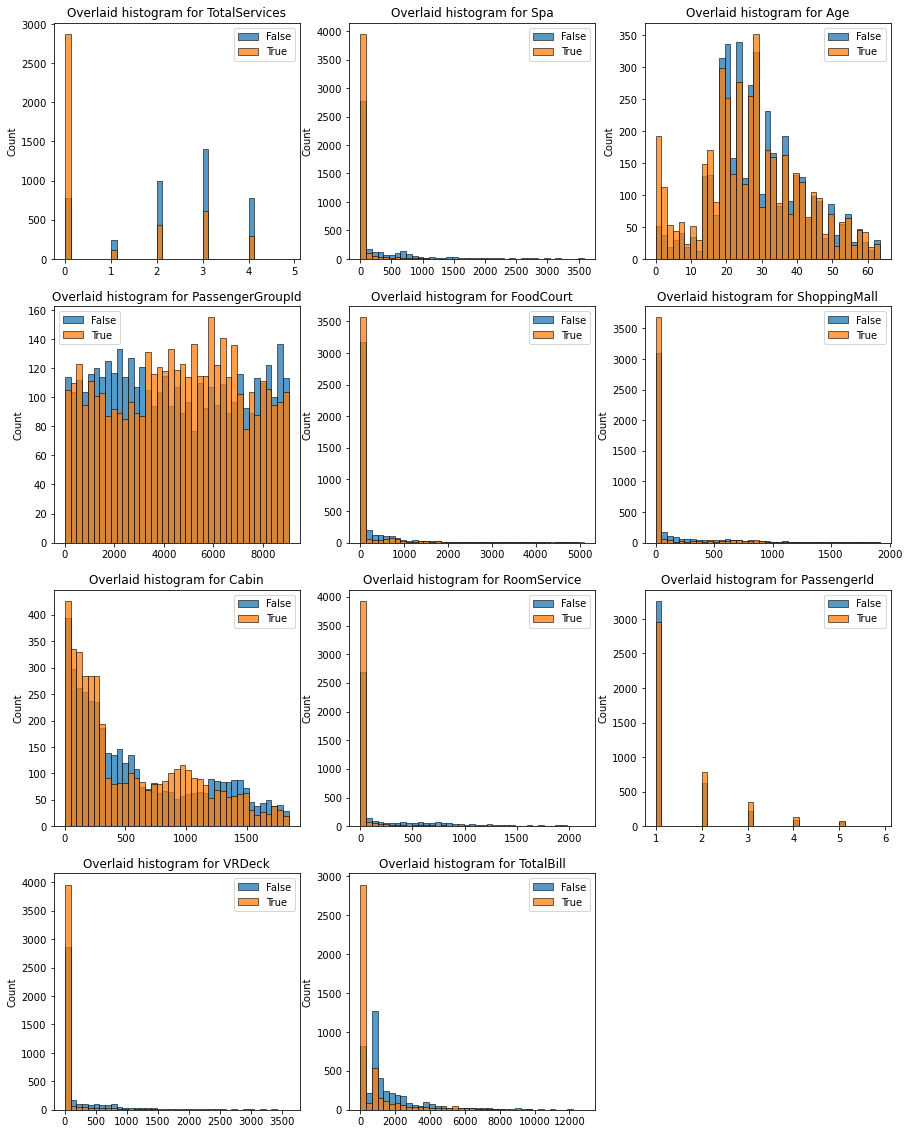

Latency (hh:mm:ss.ms):0:00:04.763453
Features mapped: ['TotalServices', 'Spa', 'Age', 'PassengerGroupId', 'FoodCourt', 'ShoppingMall', 'Cabin', 'RoomService', 'PassengerId', 'VRDeck', 'TotalBill']


'\n'

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
%matplotlib inline
"""
Will generate a report with 3 columns, and as many rows as there are features
to fill those columns representing the data in comparison to the label data.

The goal of this function is to help visualize the data. 
"""
@Augury.method
def __plot_continuous_features(self,*, axes, colors, row_i, col_i):
  continuous_features, data_clean, label, labels_unique = \
    self._attr('continuous_features_', 'data_clean_', 'label_', 'labels_unique_')
  for feature in continuous_features:
    column_ = "%s_clean" % feature
    bars = [data_clean[data_clean[label] == _label][column_] 
                 for _label in labels_unique]
    xmin = min([_bar.min() for _bar in bars])
    xmax = max([_bar.max() for _bar in bars])
    width = (xmax - xmin) / 40
    ax = axes[row_i,col_i]
    for _i, _bar in enumerate(bars):
      sns.histplot(list(_bar), color=colors[_i % len(colors)],
                   bins=np.arange(xmin,xmax,width), ax=ax)
    ax.legend(labels_unique)
    ax.title.set_text('Overlaid histogram for {}'.format(feature))
    col_i = (col_i + 1) % 3
    row_i = row_i + 1 if col_i % 3 == 0 else row_i
  # Clean up any empty columns
  while not col_i % 3 == 0:
    axes[row_i,col_i].set_axis_off()
    col_i += 1
  #plt.tight_layout()
  plt.show()
@Augury.method
def continuous_shape_report(self, plt=plt, dt=dt, sns=sns, np=np):
  continuous_features, = self._attr('continuous_features_')
  num_rows = len(continuous_features) // 3 + (len(continuous_features) % 3 > 0)
  fig,axes = plt.subplots(num_rows,3, figsize=(15,5 * num_rows))
  prop_cycle = plt.rcParams['axes.prop_cycle']
  kwargs = {
    'axes': axes, 'colors' : prop_cycle.by_key()['color'],
    'row_i' : 0, 'col_i' : 0, 
  }
  self._latency(self.__plot_continuous_features)(**kwargs)
  print("Features mapped: {}".format(continuous_features))
augur.continuous_shape_report()
"""
"""
# Graphs to review shape of continuous features

Based on the above plots - we may need to transform some of them so that they appear more Gaussian in Distribution.

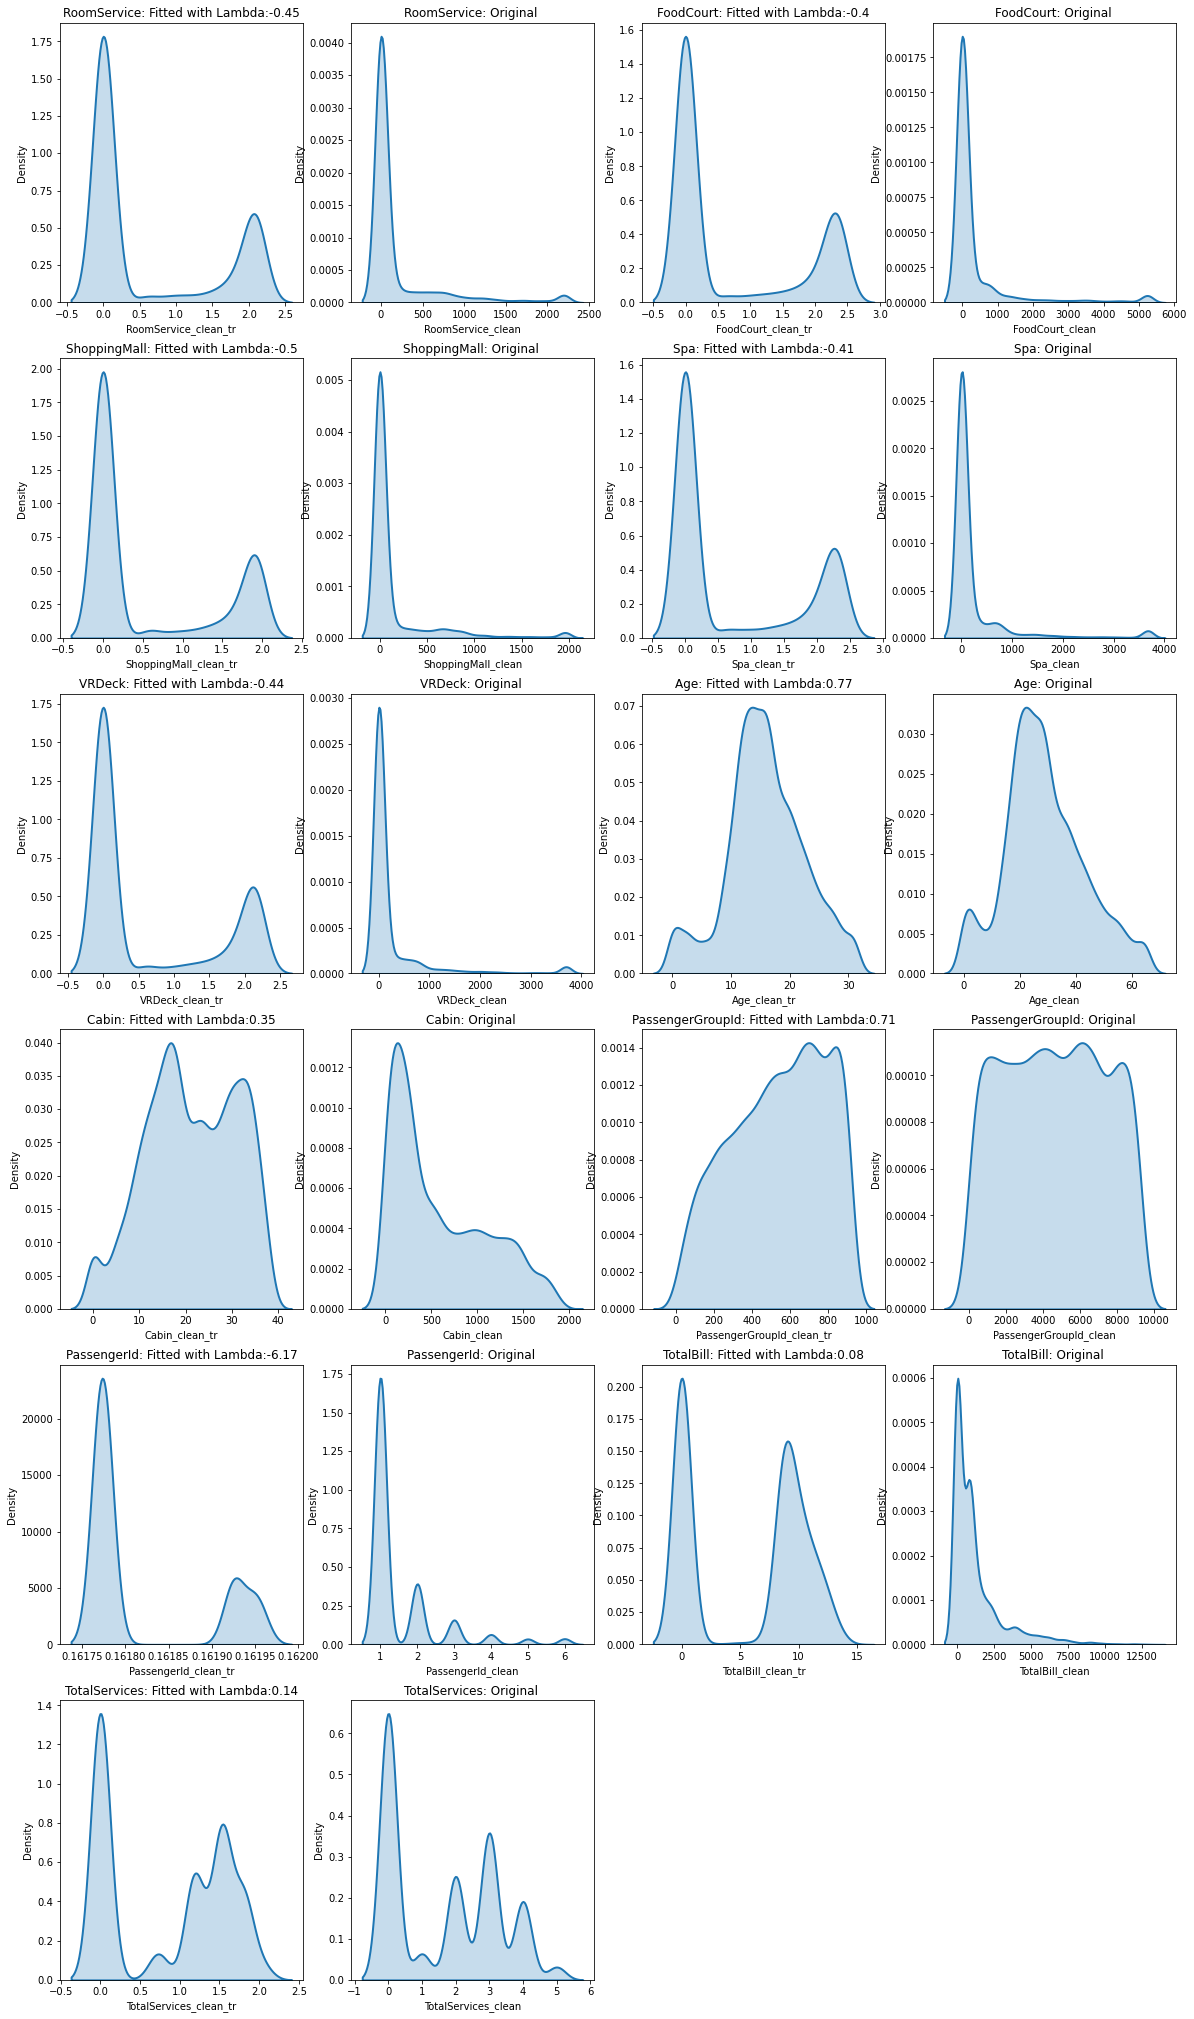

Latency (hh:mm:ss.ms):0:00:04.453198


'\n'

In [79]:
from scipy.stats import boxcox
### BoxCox Plots
# For the specific examples from `titanic-spaceship` we can see that Age is normally distributed
# but we'll include it to confirm the shape remains consistent - however the other features which
# relate to purchases seem to have more of a poisson type curve, where there
# are a lot of individuals who did not make any purchases, as such it might be
# beneficial to transform these to more normal looking shapes.
CONTINUOUS_FEATURES_BOXCOXPLOTS = {
    "columns": ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Age",
                "Cabin", "PassengerGroupId", "PassengerId", "TotalBill", "TotalServices"],
}
"""
Plot Box Cox transformations, adds "_tr" columns to the data_clean attribute, 
and records the lambda used in the "_stats" attr.
"""
@Augury.method
def box_cox_plots(self, columns=[]):
  data_raw, = self._attr('data_raw_')
  # Check columns exists in dataset
  self._input_guard(lambda x, y: set(x) and set(x).issubset(y), 
                      columns, data_raw.columns)
  self.__box_cox_plots(*columns)
@Augury.method
def __box_cox_plots(self, *features, plt=plt, dt=dt, sns=sns):
  data_clean, = self._attr('data_clean_')
  _rows = len(features) // 2 + (len(features) % 2 > 0)
  fig,axes = plt.subplots(_rows, 4, figsize=(20, 6 * _rows))
  self._latency(self.__plot_boxcox)(features=features, data_clean=data_clean, 
                                    axes=axes)
@Augury.method
def __plot_boxcox(self, *, features, data_clean, axes):
  transformations, row_i, col_i = [], 0, 0 
  for feature in features:
    _column = "%s_clean" % feature
    column_tr = "%s_tr" % _column
    data_clean[column_tr], fitted_lambda = self.__call_boxcox(data=data_clean, 
                                                              column=_column)
    # Save Lambda
    transformations.append((feature, fitted_lambda))
    ax = axes[row_i, col_i]
    ax.title.set_text("{}: Fitted with Lambda:{}".format(feature, round(fitted_lambda,2)))
    axes[row_i, col_i + 1].title.set_text(
        "{}: Original ".format(feature))
    sns.kdeplot(data_clean[_column], fill=True, linewidth=2, ax = axes[row_i, col_i + 1])
    sns.kdeplot(data_clean[column_tr], fill=True, linewidth=2, ax = ax)
    col_i = (col_i + 2) % 4
    row_i = row_i + 1 if col_i % 4 == 0 else row_i
  self._attr(boxcox_pipeline_=transformations)
  while(col_i % 4 > 0):
    axes[row_i,col_i].set_axis_off()
    col_i +=1
  #plt.tight_layout()
  plt.show()
@Augury.method
def __call_boxcox(self, lmbda=None, boxcox=boxcox, *, data, column):
  c = abs(data[column].min()) + 1
  _data = data[column] + c
  return boxcox(_data) if lmbda is None else boxcox(_data, lmbda)  
augur.box_cox_plots(**CONTINUOUS_FEATURES_BOXCOXPLOTS)
"""
"""
# Review plots of BoxCox Transformations. 

#### Transform to Numerical Indicators

In [80]:
from sklearn.preprocessing import OrdinalEncoder
from pandas.api.types import is_numeric_dtype

"""
Checks data for non-numeric values and converts to integers.
"""
@Augury.method
def __transform(self,*, _target, column, stats_attr):
  stats_,  = self._attr(overwrite=False, **{stats_attr: {}})
  try:
    _target["%s_tr" % column] = stats_['enc'].transform(
        _target[column].values.reshape(-1,1))
  except:
    # Typically thrown due to bool mixed with str... so casting
    _target["%s_tr" % column] = stats_['enc'].transform(
        _target[column].astype(str).values.reshape(-1,1))
@Augury.method
def __encode(self, *, enc, _target, column, stats_attr):
  stats_,  = self._attr(overwrite=False, **{stats_attr: {}})
  # Reshaping so that we can encode one column at a time
  try:
    stats_['enc'] = enc.fit(_target[[column]].values.reshape(-1,1))
  except:
    # Most likely getting an error for booleans where added a 3rd cat.
    # for handling NaNs
    stats_['enc'] = enc.fit(_target[[column]].astype(str).values.reshape(-1,1))
  self._attr(**{stats_attr:stats_})
@Augury.method
def numeric_transformation(self, data='data_clean_', is_numeric_dtype=is_numeric_dtype,
                           OrdinalEncoder=OrdinalEncoder, transform=True, encode=True):
  _target, = self._attr(data)
  for column in _target.columns:
    if is_numeric_dtype(_target[column]):
      continue
    if column.endswith("_tr"):
      continue
    enc = OrdinalEncoder()
    # Save Encoder (needed for test)
    stats_attr = "%s_stats_" % column
    if encode == True:
      self.__encode(enc=enc, _target=_target, column=column, stats_attr=stats_attr)
    if transform == True:
      self.__transform(_target=_target, column=column, stats_attr=stats_attr)
  return self
augur.numeric_transformation()
"""
"""
augur.data_clean_

,Transported,HomePlanet_clean,CryoSleep_clean,Destination_clean,VIP_clean,Cabin_clean,CabinDeck_clean,CabinSide_clean,PassengerGroupId_clean,PassengerId_clean,...,PassengerGroupId_clean_tr,PassengerId_clean_tr,TotalBill_clean_tr,TotalServices_clean_tr,HomePlanet_clean_tr,CryoSleep_clean_tr,Destination_clean_tr,VIP_clean_tr,CabinDeck_clean_tr,CabinSide_clean_tr
0,False,Europa,False,TRAPPIST-1e,False,0,B,P,1,1.0,...,1.663689,0.161773,0.000000,0.000000,1.0,0.0,3.0,0.0,1.0,1.0
1,True,Earth,False,TRAPPIST-1e,False,0,F,S,2,1.0,...,2.359619,0.161773,8.626384,2.040256,0.0,0.0,3.0,0.0,5.0,2.0
2,False,Europa,False,TRAPPIST-1e,True,0,A,S,3,1.0,...,3.006240,0.161773,12.831762,1.808143,1.0,0.0,3.0,2.0,0.0,2.0
3,False,Europa,False,TRAPPIST-1e,False,0,A,S,3,2.0,...,3.006240,0.161926,12.141384,1.808143,1.0,0.0,3.0,0.0,0.0,2.0
4,True,Earth,False,TRAPPIST-1e,False,1,F,S,4,1.0,...,3.616102,0.161773,9.293143,2.040256,0.0,0.0,3.0,0.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,Europa,False,55 Cancri e,True,98,A,P,9276,1.0,...,919.732424,0.161773,12.721259,1.532116,1.0,0.0,0.0,2.0,0.0,1.0
8689,False,Earth,True,PSO J318.5-22,False,1499,G,S,9278,1.0,...,919.873323,0.161773,0.000000,0.000000,0.0,2.0,1.0,0.0,6.0,2.0
8690,True,Earth,False,TRAPPIST-1e,False,1500,G,S,9279,1.0,...,919.943770,0.161773,10.242830,0.728397,0.0,0.0,3.0,0.0,6.0,2.0
8691,False,Europa,False,55 Cancri e,False,608,E,S,9280,1.0,...,920.014214,0.161773,11.928666,1.532116,1.0,0.0,0.0,0.0,4.0,2.0


## Feature Scaling & Optimal Count

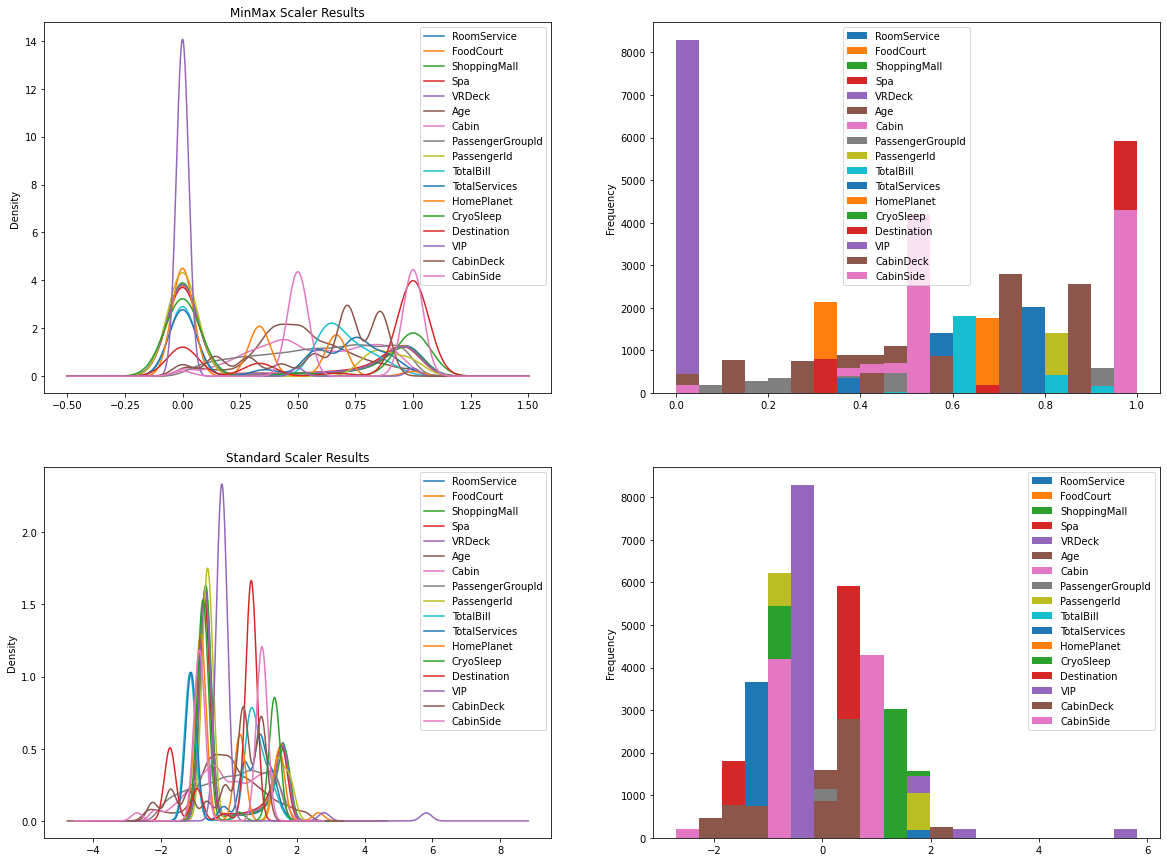

Latency (hh:mm:ss.ms):0:00:07.104615


'\n'

In [81]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
"""
Displays Graphs for Comparing MinMax vs Standard.
"""
@Augury.method
def set_data_final(self, test=False):
  data_clean, label, data_test_clean = self._attr('data_clean_', 'label_', 'data_test_clean_')
  data_final, data_test_final, = self._attr(
                  overwrite=False, data_final_=pd.DataFrame(data_clean[label]), 
                  data_test_final_=pd.DataFrame())  
  _target, _ref = (data_final, data_clean) if test == False else \
    (data_test_final, data_test_clean)
  columns_priority = [_c for _c in data_clean.columns if _c.endswith("_tr")]
  columns_processed = {}
  for column_ in columns_priority:
    column = column_.split("_")[0]
    _target[column] = _ref[column_]
    columns_processed[column] = 1
  for column_ in _ref.columns:
    column = column_.split("_")[0]
    if column in columns_processed:
      continue
    _target[column] = _ref[column_]
  return self
@Augury.method
def scaler_report(self, dt=dt, plt=plt,MinMaxScaler=MinMaxScaler, 
                  StandardScaler=StandardScaler, pd=pd):
  data_final, label = self._attr('data_final_','label_')
  fig,axes = plt.subplots(2, 2, figsize=(20, 15))
  self._latency(self.__plot_scaler_report)(data_final=data_final, label=label, 
                                           axes=axes)
@Augury.method
def __plot_scaler_report(self, *,data_final, label, axes):
  _features = data_final.drop([label], axis=1)
  # MinMax
  minmax_scaler, standard_scaler = self._attr(minmax_scaler_=MinMaxScaler().fit(_features), 
                                              standard_scaler_=StandardScaler().fit(_features))
  minmax_data, standard_data = \
  self._attr(data_minmax_scaled_=pd.DataFrame(minmax_scaler.transform(_features), 
                                   index=_features.index, columns=_features.columns),
             data_standard_scaled_=pd.DataFrame(standard_scaler.transform(_features),
                                   index=_features.index, columns=_features.columns))
  row_i, col_i = 0, 0
  axes[row_i, col_i].title.set_text("MinMax Scaler Results")
  for _data in [minmax_data, standard_data]:
    _data.plot(kind='kde', ax=axes[row_i,col_i])
    _data.plot(kind='hist', bins=20, ax=axes[row_i,col_i + 1])
    row_i += 1
  axes[row_i - 1, col_i].title.set_text("Standard Scaler Results")
  plt.show()
augur.set_data_final().scaler_report()
"""
"""
# View Results Scaled to decide which scaler to use.

In [82]:
# Based on the above graphs, and knowing that the data generally isn't normally
# distributed - will set the scaler to be MinMax
SCALAR_CONFIG = {
    'scaler' : 'minmax' # minmax | standard
}
"""
Sets the scaler to be used on test.
"""
@Augury.method
def set_scaler(self, scaler='minmax'):
  self._input_guard(lambda x: x in ['minmax', 'standard'], scaler)
  _scaler, data = self._attr("%s_scaler_" % scaler, "data_%s_scaled_" % scaler)
  self._attr(scaler_=_scaler, data_scaled_=data)
augur.set_scaler(**SCALAR_CONFIG)
"""
"""
augur.data_scaled_

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age,Cabin,PassengerGroupId,PassengerId,TotalBill,TotalServices,HomePlanet,CryoSleep,Destination,VIP,CabinDeck,CabinSide
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.667712,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.0,1.000000,0.0,0.142857,0.5
1,0.908478,0.623182,0.820133,0.956960,0.835242,0.452940,0.000000,0.000758,0.000000,0.615156,1.000000,0.000000,0.0,1.000000,0.0,0.714286,1.0
2,0.845200,0.994508,0.000000,1.000000,0.843960,0.914150,0.000000,0.001462,0.000000,0.915045,0.886233,0.333333,0.0,1.000000,1.0,0.000000,1.0
3,0.000000,0.974812,0.969383,0.998460,0.926499,0.584550,0.000000,0.001462,0.832686,0.865814,0.886233,0.333333,0.0,1.000000,0.0,0.000000,1.0
4,0.953915,0.846518,0.938955,0.957886,0.394010,0.326231,0.020565,0.002126,0.000000,0.662703,1.000000,0.000000,0.0,1.000000,0.0,0.714286,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.000000,1.000000,0.000000,0.985678,0.873979,0.694769,0.302909,0.999693,0.000000,0.907165,0.750943,0.333333,0.0,0.000000,1.0,0.000000,0.5
8689,0.000000,0.000000,0.000000,0.000000,0.000000,0.359014,0.914520,0.999847,0.000000,0.000000,0.000000,0.000000,1.0,0.333333,0.0,0.857143,1.0
8690,0.000000,0.000000,0.999428,0.254357,0.000000,0.483029,0.914754,0.999923,0.000000,0.730426,0.357013,0.000000,0.0,1.000000,0.0,0.857143,1.0
8691,0.000000,0.969900,0.000000,0.941285,0.998317,0.570370,0.643956,1.000000,0.000000,0.850644,0.750943,0.333333,0.0,0.000000,0.0,0.571429,1.0


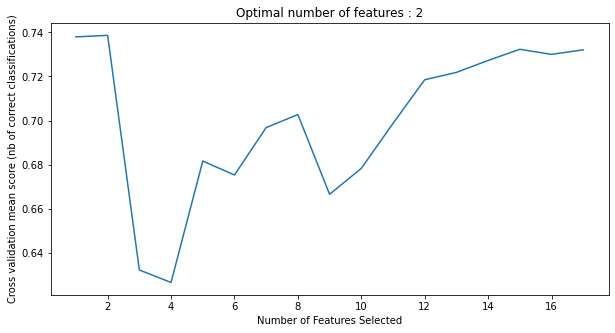

Latency (hh:mm:ss.ms):0:00:00.245852
Features passed to data_compressed_:
TotalBill
TotalServices


,TotalBill,TotalServices
0,0.000000,0.000000
1,0.615156,1.000000
2,0.915045,0.886233
3,0.865814,0.886233
4,0.662703,1.000000
...,...,...
8688,0.907165,0.750943
8689,0.000000,0.000000
8690,0.730426,0.357013
8691,0.850644,0.750943


In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
import joblib
### Feature Analysis using RFECV

"""
Report which helps identify key features.
Could be used to optimize model training.
"""
@Augury.method
def __set_and_fit_rfecv(self, RFECV=RFECV, *, estimator, X, y):
  _rfecv = RFECV(estimator=estimator)
  _rfecv.fit(X, y)
  return _rfecv
@Augury.method
def __set_compressed_features(self, *, rfecv, data_scaled):
  features_compressed = []
  print("Features passed to data_compressed_:")
  for _i, _f in enumerate(rfecv.ranking_):
    if _f == 1:
      feature = rfecv.feature_names_in_[_i]
      features_compressed.append(feature)
      print(feature)
  self._attr(data_compressed_=data_scaled[features_compressed])
@Augury.method
def feature_analysis(self, max_depth=None, memory=joblib.Memory(AUGURY_CACHE, verbose=0),
                     RandomForestClassifier=RandomForestClassifier, **kwargs):
  data_scaled, data_final, label = self._attr('data_scaled_', 'data_final_', 'label_')
  max_depth = len(data_scaled.columns) // 2 if max_depth is None else max_depth
  rf = RandomForestClassifier(max_depth=max_depth, **kwargs)
  cache_rfecv = memory.cache(self.__set_and_fit_rfecv, ignore=['self', 'RFECV'])
  rfecv = self._latency(self.__plot_optimal_features)(rf=rf, data_scaled=data_scaled, 
    data_final=data_final, label=label, cache_rfecv=cache_rfecv)
  self.__set_compressed_features(rfecv=rfecv, data_scaled=data_scaled)
@Augury.method
def __plot_optimal_features(self, *,rf, data_scaled, data_final, label, cache_rfecv):
  rfecv = cache_rfecv(RFECV=RFECV, estimator=rf, X=data_scaled, y=data_final[label])
  # Plot number of features VS. cross-validation scores
  plt.figure(figsize=(10,5))
  plt.xlabel("Number of Features Selected")
  plt.ylabel("Cross validation mean score (nb of correct classifications)")
  plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
  plt.title("Optimal number of features : %d" % rfecv.n_features_)
  plt.show()
  return rfecv
augur.feature_analysis()
"""
"""
# Gut check on fetures to send to model
augur.data_compressed_

In [30]:
### TODO: Add Correlation Heatmap and process functions for removing functions (using compressed data)

## Train / Validation Split

In [84]:
from sklearn.model_selection import train_test_split
"""
"""
@Augury.method
def confirm_splits(self):
  # Confirm split
  for _dataset in ["y", "y_compressed"]:
    data_final, label = self._attr('data_final_', 'label_')
    for _split in ["%s_train_" % _dataset, "%s_val_" % _dataset]:
      print("%s as %% of rows" % _split)
      print(round(len(getattr(self, _split)) / data_final[label].shape[0], 2))
@Augury.method
def split_hash(self, prefix="",*, X, y):
  split_tuple = train_test_split(X, y, test_size=0.2)
  return {
    'X_%strain_' % prefix  : split_tuple[0], 
    'X_%sval_' % prefix    : split_tuple[1], 
    'y_%strain_' % prefix  : split_tuple[2], 
    'y_%sval_' % prefix    : split_tuple[3]    
  }
@Augury.method
def set_train_val_data(self, train_test_split=train_test_split):
  data_final, data_scaled, data_compressed, label = \
    self._attr('data_final_', 'data_scaled_', 'data_compressed_', 'label_')
  _labels, _features, features_compressed = data_final[label], data_scaled, data_compressed
  _split_dict = {
    **self.split_hash(X=_features, y=_labels),
    **self.split_hash(prefix="compressed_", X=features_compressed, y=_labels),   
  }
  self._attr(**_split_dict)
  return self
augur.set_train_val_data().confirm_splits()
"""
"""
# Split and then confirm splits

y_train_ as % of rows
0.8
y_val_ as % of rows
0.2
y_compressed_train_ as % of rows
0.8
y_compressed_val_ as % of rows
0.2


'\n'

## Principal Component Analysis

In [85]:
from sklearn.decomposition import PCA
# Perform with data_scaled and continuous features - fed to KMeans
"""
"""
@Augury.method
def get_continuous_data(self, X, np=np, dt=dt):
  continuous_features, = self._attr('continuous_features_')
  _columns = np.intersect1d(continuous_features, X.columns)
  return (X[_columns], _columns)
@Augury.method
def pca_analysis(self, PCA=PCA, data=('X_train_','y_train_','X_val_','y_val_')):
  X_train, y_train, X_val, y_val = self._attr(*data)
  X_continuous_train, _ = self.get_continuous_data(X_train)
  X_continuous_val, _ = self.get_continuous_data(X_val)
  _explained_variance_ratio, _attempts = 0, 1
  while(_explained_variance_ratio < 0.80 and _attempts < len(X_train.columns)):
    _attempts += 1
    pca=PCA(n_components=(_attempts))
    pca.fit(X_continuous_train)
    _explained_variance_ratio = sum(pca.explained_variance_ratio_)
  if _attempts < 2:
    # Could not perform PCA
    X_continuous_train['PCA'] = 1
    X_continuous_val['PCA'] = 1
    self._attr(X_pca_train_=X_continuous_train.to_numpy(), y_pca_train_=y_train, 
               X_pca_val_=X_continuous_val.to_numpy(), y_pca_val_=y_val)
    print("Unable to perform PCA")
  else:
    self._attr(X_pca_train_=pca.transform(X_continuous_train), y_pca_train_=y_train)
    self._attr(X_pca_val_=pca.transform(X_continuous_val), y_pca_val_=y_val)
    print("PCA Analysis set {} components. With Total Explained Variance Ratio: {}%".format(
        _attempts, round(_explained_variance_ratio * 100,2)))
augur.pca_analysis(data=('X_compressed_train_', 'y_compressed_train_', 
                         'X_compressed_val_', 'y_compressed_val_'))
"""
"""
# Rought PCA Analysis (will be used to visualize clusters)

PCA Analysis set 2 components. With Total Explained Variance Ratio: 100.0%


'\n'

### KMeans Benchmark

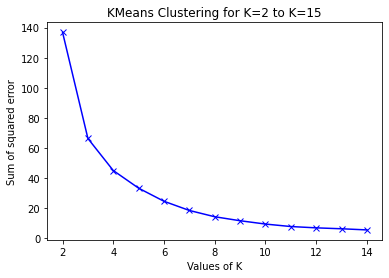

Latency (hh:mm:ss.ms):0:00:11.999751


'\n'

In [86]:
from sklearn.cluster import KMeans
# Trying to increase my knowledge of clustering so adding here since it's
# handled differently than the other models which will be presented.

"""
Generates an Elbow Report for KMeans Analysis
"""
@Augury.method
def kmeans_elbow_report(self):
  self._latency(self.__kmeans_elbow_report)()
@Augury.method
def __kmeans_elbow_report(self, dt=dt, plt=plt):
  X_pca_train, = self._attr('X_pca_train_')
  Sum_of_squared_distances = []
  K = range(2,15)
  for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X_pca_train)
    Sum_of_squared_distances.append(kmeans.inertia_)
  plt.plot(K,Sum_of_squared_distances,'bx-')
  plt.xlabel('Values of K') 
  plt.ylabel('Sum of squared error') 
  plt.title('KMeans Clustering for K=2 to K=15')
  plt.show()
augur.kmeans_elbow_report()
"""
"""
# Elbow report for KMeans Clustering

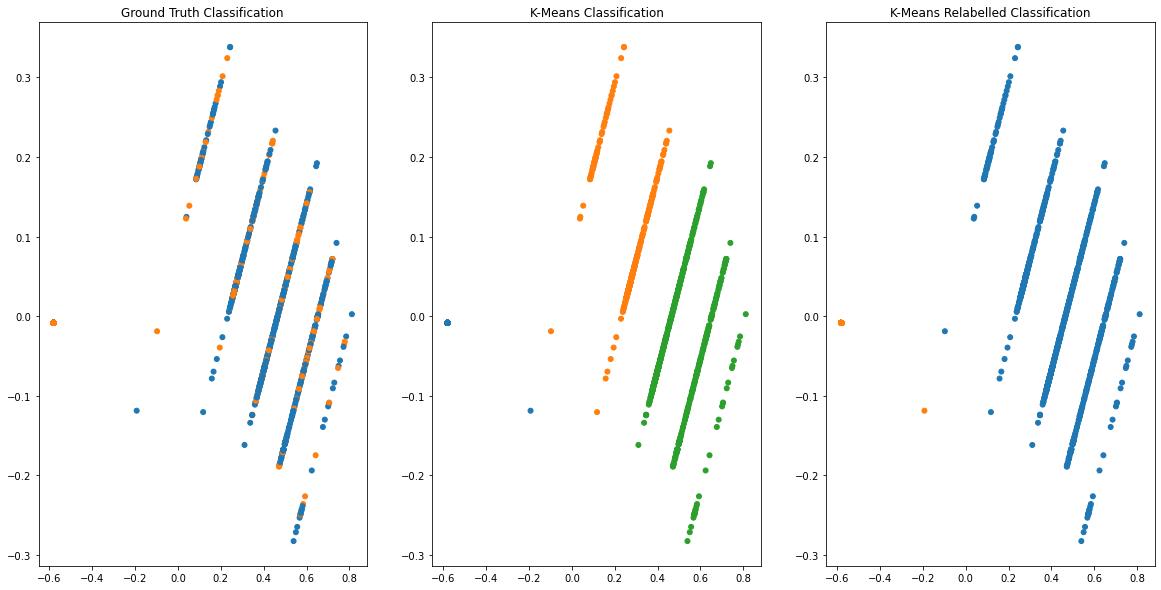

kmeans Performance -- Accuracy: 75.22% / Precision: 75.96% / Recall: 75.22% / Latency (hh:mm:ss.ms): 0:00:00.129827


'\n'

In [87]:
from sklearn.metrics import classification_report
from sklearn.metrics.cluster import contingency_matrix
KMEANS_ANALYSIS_CONFIG = {
    'n_clusters' : 3
}
"""
Generates a Cluster Report based on PCA-1 and PCA-2
Relabels according to label based on a contingency matrix, whic is used
for traditional accuracy, precision, recal, reporting.
"""
@Augury.method
def print_performance(self, *, model, accuracy, precision, recall, latency):
  (accuracy, precision, recall) = (round(accuracy * 100, 2), round(precision * 100, 2), round(recall * 100, 2))
  print("{} Performance -- Accuracy: {}% / Precision: {}% / Recall: {}% / Latency (hh:mm:ss.ms): {}".format(
      model, accuracy, precision, recall, latency
  ))
@Augury.method
def set_performance(self, *, model, accuracy, precision, recall, latency, 
                    output_string=False):
  models, best_accuracy_, best_precision_, best_recall_, best_latency = self._attr(
      overwrite=False, models_={}, best_accuracy_=("",0), best_precision_=("",0),
      best_recall_=("",0), best_latency_=("",0)
  )
  _t = { 'accracy' : accuracy, 'precision': precision, 'recall' : recall, 
        'latency': latency } 
  models[model] = {**_t, **models[model]} if model in models else _t
  self._attr(models_=models)
  for _top in ['accuracy', "precision", 'recall']:
    _best = "best_%s_" % _top
    if locals()[_top] > locals()[_best][1]:
      self._attr(**{_best:(model,locals()[_top])})
  if not best_latency[1] or latency < best_latency[1]:
    self._attr(best_latency_=(model, latency))
  if output_string:
    self.print_performance(model=model, accuracy=accuracy,
                      precision=precision, recall=recall, latency=latency)
@Augury.method
def kmeans_plot_axes(self, *, axes, x, y, c, title, plt=plt, np=np):
  prop_cycle = plt.rcParams['axes.prop_cycle']
  colors = prop_cycle.by_key()['color']
  colors_len = len(colors)
  color_theme = np.array(colors)

  axes.scatter(x=x, y=y, c=color_theme[c % colors_len], s=25)
  axes.title.set_text(title)
@Augury.method
def kmeans_results(self, classification_report=classification_report, *, relabel,
                   time_taken):
  y_pca_val, = self._attr('y_pca_val_')
  kmeans_results = classification_report(y_pca_val, relabel, output_dict=True, 
                                         zero_division=0)
  self.set_performance(model='kmeans', accuracy=kmeans_results['accuracy'],
                       precision=kmeans_results['weighted avg']['precision'], 
                       recall=kmeans_results['weighted avg']['recall'],
                       latency=time_taken, output_string=True)
@Augury.method
def kmeans_analysis(self, n_clusters=2, plt=plt, KMeans=KMeans, dt=dt, np=np, 
                    contingency_matrix=contingency_matrix):
  self._input_guard(lambda x: isinstance(x, int), n_clusters)
  X_pca_val, y_pca_val = self._attr('X_pca_val_', 'y_pca_val_')
  fig,axes = plt.subplots(1,3, figsize=(20,10))
  clustering = KMeans(n_clusters=n_clusters)
  start_ = dt.now()
  clustering.fit(X_pca_val)
  time_taken = dt.now() - start_
  self.kmeans_plot_axes(axes=axes[0], x=X_pca_val[:,0], y=X_pca_val[:,1], 
                    c=y_pca_val, title='Ground Truth Classification')
  self.kmeans_plot_axes(axes=axes[1], x=X_pca_val[:,0], y=X_pca_val[:,1], 
                    c=clustering.labels_, title='K-Means Classification')
  _n = contingency_matrix(y_pca_val, clustering.labels_)
  choose_arr = _n.argmax(axis=0)
  relabel = np.choose(clustering.labels_, choose_arr).astype(np.int64)
  self.kmeans_plot_axes(axes=axes[2], x=X_pca_val[:,0], y=X_pca_val[:,1], 
                    c=relabel, title='K-Means Relabelled Classification')  
  plt.show()
  self.kmeans_results(relabel=relabel, time_taken=time_taken)
augur.kmeans_analysis(**KMEANS_ANALYSIS_CONFIG)
"""
"""
# Display cluster labels vs. Truth Labels

## Model Selection
|                          | Label Type | Training Speed | Performance Speed | Simplicity | Performance | Performance With Limited Data |
|:------------------------:|:----------:|:--------------:|:-----------------:|:----------:|:-----------:|:-----------------------------:|
|    logistic-regression   |    class   |      high      |        high       |     med    |     low     |              high             |
| support-vector-machines  |    class   |       low      |        med        |     low    |     med     |              high             |
|   multilayer-perceptron  |    both    |       low      |        med        |     low    |     high    |              low              |
|       random-forest      |    both    |       med      |        med        |     low    |     med     |              low              |
|       boosted-trees      |    both    |       low      |        high       |     low    |     high    |              low              |

### Hyperparameter Tuning

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
import warnings as warnings
# KMeans couldn't produce obvious cluster, so will try some other models.
# Going to focus on performance so will select SVM, multilater-perceptron, and boosted tree to compare.
"""
"""
@Augury.method
def prep_tuning(self, clear_cache=False, ConvergenceWarning=ConvergenceWarning,
                warnings=warnings, memory=joblib.Memory(AUGURY_CACHE, verbose=0)):
  # Removing ConvergenceWarning from cells to keep cell results clean.
  warnings.simplefilter('ignore', category=ConvergenceWarning)
  if clear_cache:
    memory.clear(warn=False)
@Augury.method
def __call_fit(self, cv, X, y):
  return cv.fit(X, y.values.ravel())
@Augury.method
def feature_importance_report(self,model, X, np=np, plt=plt):
  if not 'feature_importances_' in dir(model.best_estimator_):
    return
  feat_imp = model.best_estimator_.feature_importances_
  indices = np.argsort(feat_imp)
  plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
  plt.barh(range(len(indices)), feat_imp[indices], align='center')
  plt.show()
@Augury.method
def save_tuning_results(self, *, name, model):
  models, = self._attr('models_')
  if not name in models:
    models[name] = {}
  models[name]['model'] = model
  self._attr(models_=models)
@Augury.method
def hypertune_models(self, models, data=('X_train_', 'y_train_'), GridSearchCV=GridSearchCV, dt=dt,
                     memory=joblib.Memory(AUGURY_CACHE, verbose=0),**kwargs):
  self._input_guard(lambda: len(models) <= 3)
  self.prep_tuning(**kwargs)
  models_, = self._attr('models_')
  for _m in models:
    valid_keys = ['name', 'model', 'parameters']
    _vals = self._hash(_m, *valid_keys)
    for _i, _val in enumerate(_vals):
      assert not _val is None, "Missing {} key".format(valid_keys[_i])
    X, y = self._attr(*data)
    name, model, parameters = _vals
    GridSearchCV = memory.cache(GridSearchCV)
    cv = GridSearchCV(model, parameters, cv=5)
    print('{} ...GridSearchCV (this may take a while)\n======='.format(name))
    call_fit = memory.cache(self.__call_fit, ignore=['self'])
    model_ = self._latency(call_fit)(cv, X, y)
    print('Score (Mean Cross Validated): {}% | BEST PARAMS: {}\n'.format(
        round(model_.best_score_ * 100, 2), model_.best_params_))
    self.feature_importance_report(model_, X)
    self.save_tuning_results(name=name, model=model_)
"""
"""

'\n'

LogisticRegression ...GridSearchCV (this may take a while)
Latency (hh:mm:ss.ms):0:00:33.225453
Score (Mean Cross Validated): 75.22% | BEST PARAMS: {'C': 0.1, 'class_weight': None}

SupportVectorMachines ...GridSearchCV (this may take a while)
Latency (hh:mm:ss.ms):0:01:43.972104
Score (Mean Cross Validated): 76.86% | BEST PARAMS: {'C': 10, 'kernel': 'rbf'}

GradientBoosting ...GridSearchCV (this may take a while)
Latency (hh:mm:ss.ms):0:17:24.006674
Score (Mean Cross Validated): 79.88% | BEST PARAMS: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}



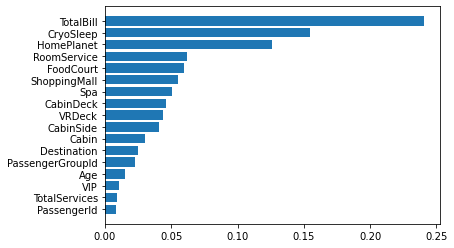

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
"""
Default Configs listed below
"""
## Note Regression has not been tested.
class_ = augur.label_type_ == 'categorical'
##
LogisticRegressionConfig = {
  'name'      : 'LogisticRegression',
  'model'     : LogisticRegression(),
  'parameters': {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'class_weight' : [None, 'balanced']
  }
} if class_ else None
SupportVectorMachinesConfig = {
  'name'      : 'SupportVectorMachines',
  'model'     : SVC(),
  'parameters': {
    'kernel': ['rbf', 'linear'],
    'C'     : [0.1, 1, 10, 100]
  },
} if class_ else None
MultilaterPerceptronConfig = {
  'name'      : 'MultilaterPerceptron',
  'model'     : MLPClassifier() if class_ else MLPRegressor(),
  'parameters': {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation'        : ['relu', 'tanh', 'logistic'],
    'learning_rate'     : ['constant', 'invscaling', 'adaptive']
  }
}
RandomForestConfig = {
  'name'      : 'RandomForest',
  'model'     : RandomForestClassifier() if class_ else RandomForestRegressor(),
  'parameters': {
    'n_estimators'  : [5, 50, 250, 500],
    'max_depth'     : [1, 3, 5, 7, 9],
    'learning_rate' : [0.01, 0.1, 1, 10, 100]
  }
}
GradientBoostingConfig = {
  'name'      : 'GradientBoosting',
  'model'     : XGBClassifier() if class_ else XGBRegressor(),
  'parameters': {
    'n_estimators'  : [5, 50, 250, 500],
    'max_depth'     : [1, 3, 5, 7, 9],
    'learning_rate' : [0.01, 0.1, 1, 10, 100]
  }
}
"""
"""
MODEL_CONFIGS = [
          LogisticRegressionConfig,
          SupportVectorMachinesConfig,
          #MultilaterPerceptronConfig, 
          #RandomForestConfig, 
          GradientBoostingConfig           
]
augur.hypertune_models(MODEL_CONFIGS)

### Fit

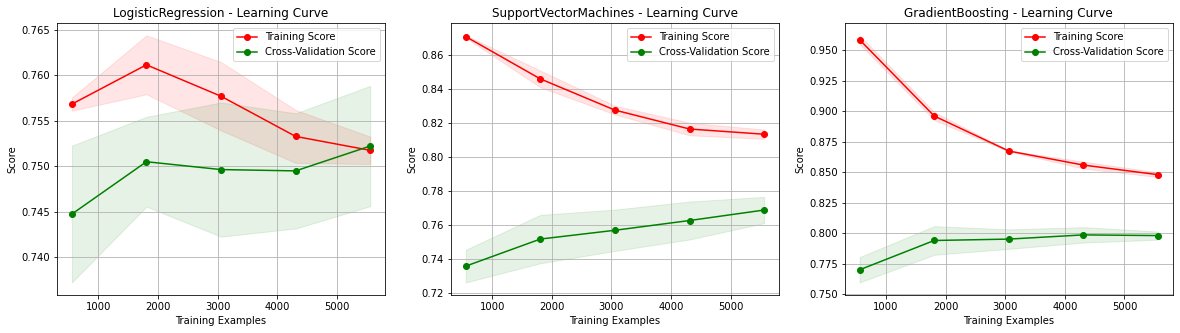

Latency (hh:mm:ss.ms):0:01:04.815767


'\n'

In [90]:
from sklearn.model_selection import learning_curve
"""
"""
@Augury.method
def __plot_learning_curve(self, models, plt=plt, dt=dt, learning_curve=learning_curve,
                        memory=joblib.Memory(AUGURY_CACHE, verbose=0), np=np, 
                        data=('X_train_','y_train_')):
  """
  Modified to display two Learning Curve graphs for side-by-side comparison,
  from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
  """
  models_, X_train, y_train = self._attr('models_', *data)
  _, axes = plt.subplots(1,3, figsize=(20,5))
  idx = 0
  for model in models:
    name = (lambda name, **_: name)(**model)
    axes[idx].set_title("%s - Learning Curve" % name)
    axes[idx].set_xlabel("Training Examples")
    axes[idx].set_ylabel("Score")
    learning_curve = memory.cache(learning_curve)
    train_sizes, train_scores, test_scores = learning_curve(
        models_[name]['model'].best_estimator_,
        X_train,
        y_train,
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes[idx].grid()
    axes[idx].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color='r',
    )
    axes[idx].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color='g',
    )
    axes[idx].plot(
        train_sizes, train_scores_mean, "o-", color='r', label='Training Score'
    )
    axes[idx].plot(
        train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score'
    )
    axes[idx].legend(loc="best")
    idx += 1
  plt.show()
@Augury.method
def plot_learning_curve(self, *args):
  self._latency(self.__plot_learning_curve)(*args)
augur.plot_learning_curve(MODEL_CONFIGS)
"""
"""
# View Model Performance

### Evaluation

In [91]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
"""
"""
@Augury.method
def evaluate_model(self, *, name, model, features, labels, dt=dt, average='binary',
                   accuracy_score=accuracy_score, precision_score=precision_score,
                   recall_score=recall_score, **kwargs):
    start_ = dt.now()
    pred = model.predict(features)
    end_ = dt.now()
    accuracy = accuracy_score(labels, pred)
    precision = precision_score(labels, pred, average=average)
    recall = recall_score(labels, pred, average=average)
    self.set_performance(model=name, accuracy=accuracy, precision=precision,
                           recall=recall, latency=end_-start_, **kwargs)    
@Augury.method
def evaluate_models(self, model_configs, memory=joblib.Memory(AUGURY_CACHE, verbose=0), 
                    **kwargs):
  models, X_train, y_train = self._attr('models_', 'X_train_', 'y_train_')
  for model in model_configs:
    name = (lambda name, **_: name)(**model)
    evaluate_model = memory.cache(self.evaluate_model, ignore=['self'])
    self.evaluate_model(name=name, model=models[name]['model'].best_estimator_, 
                        features=X_train, labels=y_train, **kwargs)
augur.evaluate_models(MODEL_CONFIGS, output_string=True)
"""
"""
# Evaluate performance of models against Valdation Data Set

LogisticRegression Performance -- Accuracy: 75.35% / Precision: 76.95% / Recall: 73.0% / Latency (hh:mm:ss.ms): 0:00:00.008108
SupportVectorMachines Performance -- Accuracy: 81.06% / Precision: 80.76% / Recall: 81.98% / Latency (hh:mm:ss.ms): 0:00:01.410910
GradientBoosting Performance -- Accuracy: 84.11% / Precision: 83.16% / Recall: 85.89% / Latency (hh:mm:ss.ms): 0:00:00.008640


'\n'

In [92]:
EVALUATION_CRITERIA = {
    'criteria': "accuracy" # one of (accuracy|precision|recall)
}
"""
"""
@Augury.method
def set_evalutation_criteria(self, *, criteria):
  self._input_guard(lambda x: x in ['accuracy', 'precision', 'recall'], criteria)
  self._attr(evaluation_criteria_=criteria)
augur.set_evalutation_criteria(**EVALUATION_CRITERIA)
"""
"""
augur.evaluation_criteria_

'accuracy'

### Tune
Will compare against compressed dataset.

In [93]:
"""
#TODO
def tune(self):
  evaluation_criteria = getattr(self, 'evaluation_criteria')
  model_name = getattr(self, "best_%s" % evaluation_criteria)[0]
  # Todo - need to refactor some of the above to be a bit less encompassing
for _func in [tune]:
  constructor_(Augury)(_func)

"""

'\n#TODO\ndef tune(self):\n  evaluation_criteria = getattr(self, \'evaluation_criteria\')\n  model_name = getattr(self, "best_%s" % evaluation_criteria)[0]\n  # Todo - need to refactor some of the above to be a bit less encompassing\nfor _func in [tune]:\n  constructor_(Augury)(_func)\n\n'

## Test
Read in File
Apply same transformation as training, and predict with best model.

In [94]:
"""
"""
augur.set_data_from_path(data_test_=TEST_PATH)
"""
"""
# View Test data
augur.data_test_

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [95]:
"""
"""
TEST_DATA_ATTRS = ('data_test_clean_', 'data_test_') # Hardcoded for now
@Augury.method
def prepare_predictions(self, pd=pd, id_column=None):
    data_test, = self._attr('data_test_')
    self._input_guard(lambda: not data_test is None)
    self._input_guard(lambda x, y: x is None or x in y, id_column, data_test.columns)
    id_column = data_test.columns[0] if id_column is None else id_column
    self._attr(predictions_=pd.DataFrame(data_test[id_column]))
    return self
augur.prepare_predictions().process_nulls(
    data=TEST_DATA_ATTRS).process_features(data=TEST_DATA_ATTRS).process_continuous_features(
        data=TEST_DATA_ATTRS).clip_continuous(data=TEST_DATA_ATTRS)
"""
"""
# View cleaned test data
augur.data_test_clean_

Feature may have already transitioned
Feature may have already transitioned
Feature may have already transitioned
Clipping Age_clean to new max of: 65.0
Clipping PassengerId_clean to new max of: 6.0
Clipping PassengerGroupId_clean to new max of: 12646.015285087455
Clipping Cabin_clean to new max of: 2128.1756437676995
Clipping RoomService_clean to new max of: 2201.4524911739763
Clipping FoodCourt_clean to new max of: 5235.53054213676
Clipping ShoppingMall_clean to new max of: 1963.490600603184
Clipping Spa_clean to new max of: 3681.082317156845
Clipping VRDeck_clean to new max of: 3700.4453698312614
Updated attr `data_clean`


,HomePlanet_clean,CryoSleep_clean,Destination_clean,VIP_clean,Cabin_clean,Age_clean,RoomService_clean,FoodCourt_clean,ShoppingMall_clean,Spa_clean,VRDeck_clean,CabinDeck_clean,CabinSide_clean,PassengerGroupId_clean,PassengerId_clean,TotalBill_clean,TotalServices_clean
0,Earth,True,TRAPPIST-1e,False,3,27.00000,0.0,0.000000,0.0,0.0,0.0,G,S,13,1.0,0.0,0
1,Earth,False,TRAPPIST-1e,False,4,19.00000,0.0,9.000000,0.0,2823.0,0.0,F,S,18,1.0,2832.0,2
2,Europa,True,55 Cancri e,False,0,31.00000,0.0,0.000000,0.0,0.0,0.0,C,S,19,1.0,0.0,0
3,Europa,False,TRAPPIST-1e,False,1,38.00000,0.0,5235.530542,0.0,181.0,585.0,C,S,21,1.0,7418.0,3
4,Earth,False,TRAPPIST-1e,False,5,20.00000,10.0,0.000000,635.0,0.0,0.0,F,S,23,1.0,645.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,False,1496,34.00000,0.0,0.000000,0.0,0.0,0.0,G,S,9266,2.0,0.0,0
4273,Earth,False,TRAPPIST-1e,False,0,42.00000,0.0,847.000000,17.0,10.0,144.0,A,A,9269,1.0,1018.0,4
4274,Mars,True,55 Cancri e,False,296,28.82793,0.0,0.000000,0.0,0.0,0.0,D,P,9271,1.0,0.0,0
4275,Europa,False,SomeThirdValue,False,297,28.82793,0.0,2680.000000,0.0,0.0,523.0,D,P,9273,1.0,3203.0,2


In [96]:
"""
"""
@Augury.method
def process_boxcox(self):
  boxcox_pipeline, data_test_clean= self._attr('boxcox_pipeline_', 'data_test_clean_')
  for rule in boxcox_pipeline:
    feature, lmbda = rule
    data_test_clean["%s_clean_tr" % feature] = self.__call_boxcox(
        lmbda=lmbda, data=data_test_clean, column="%s_clean" % feature)
  return self
augur.process_boxcox().numeric_transformation(data='data_test_clean_')
"""
"""
# View transformed data
augur.data_test_clean_

,HomePlanet_clean,CryoSleep_clean,Destination_clean,VIP_clean,Cabin_clean,Age_clean,RoomService_clean,FoodCourt_clean,ShoppingMall_clean,Spa_clean,...,PassengerGroupId_clean_tr,PassengerId_clean_tr,TotalBill_clean_tr,TotalServices_clean_tr,HomePlanet_clean_tr,CryoSleep_clean_tr,Destination_clean_tr,VIP_clean_tr,CabinDeck_clean_tr,CabinSide_clean_tr
0,Earth,True,TRAPPIST-1e,False,3,27.00000,0.0,0.000000,0.0,0.0,...,13.202132,0.161773,0.000000,0.000000,0.0,2.0,3.0,0.0,6.0,2.0
1,Earth,False,TRAPPIST-1e,False,4,19.00000,0.0,9.000000,0.0,2823.0,...,15.074296,0.161773,10.996926,1.188917,0.0,0.0,3.0,0.0,5.0,2.0
2,Europa,True,55 Cancri e,False,0,31.00000,0.0,0.000000,0.0,0.0,...,15.438187,0.161773,0.000000,0.000000,1.0,2.0,0.0,0.0,2.0,2.0
3,Europa,False,TRAPPIST-1e,False,1,38.00000,0.0,5235.530542,0.0,181.0,...,16.156523,0.161773,12.850403,1.532116,1.0,0.0,3.0,0.0,2.0,2.0
4,Earth,False,TRAPPIST-1e,False,5,20.00000,10.0,0.000000,635.0,0.0,...,16.863030,0.161773,8.407412,1.188917,0.0,0.0,3.0,0.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,False,1496,34.00000,0.0,0.000000,0.0,0.0,...,919.873323,0.161926,0.000000,0.000000,0.0,2.0,3.0,0.0,6.0,2.0
4273,Earth,False,TRAPPIST-1e,False,0,42.00000,0.0,847.000000,17.0,10.0,...,920.084656,0.161773,9.174329,1.808143,0.0,0.0,3.0,0.0,0.0,0.0
4274,Mars,True,55 Cancri e,False,296,28.82793,0.0,0.000000,0.0,0.0,...,920.225533,0.161773,0.000000,0.000000,2.0,2.0,0.0,0.0,3.0,1.0
4275,Europa,False,SomeThirdValue,False,297,28.82793,0.0,2680.000000,0.0,0.0,...,920.366401,0.161773,11.226203,1.188917,1.0,0.0,2.0,0.0,3.0,1.0


In [97]:
"""
"""
augur.set_data_final(test=True)
"""
"""
# View test data to be predicted against
augur.data_test_final_

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age,Cabin,PassengerGroupId,PassengerId,TotalBill,TotalServices,HomePlanet,CryoSleep,Destination,VIP,CabinDeck,CabinSide
0,0.000000,0.000000,0.000000,0.000000,0.000000,15.489936,1.790853,13.202132,0.161773,0.000000,0.000000,0.0,2.0,3.0,0.0,6.0,2.0
1,0.000000,1.502729,0.000000,2.365240,0.000000,11.670123,2.170658,15.074296,0.161773,10.996926,1.188917,0.0,0.0,3.0,0.0,5.0,2.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,17.301020,0.000000,15.438187,0.161773,0.000000,0.000000,1.0,2.0,0.0,0.0,2.0,2.0
3,0.000000,2.411379,0.000000,2.165285,2.134458,20.349271,0.785844,16.156523,0.161773,12.850403,1.532116,1.0,0.0,3.0,0.0,2.0,2.0
4,1.464183,0.000000,1.935781,0.000000,0.000000,12.164813,2.504102,16.863030,0.161773,8.407412,1.188917,0.0,0.0,3.0,0.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.000000,0.000000,0.000000,0.000000,0.000000,18.624695,34.919032,919.873323,0.161926,0.000000,0.000000,0.0,2.0,3.0,0.0,6.0,2.0
4273,0.000000,2.325122,1.536251,1.532658,2.017766,22.033038,0.000000,920.084656,0.161773,9.174329,1.808143,0.0,0.0,3.0,0.0,0.0,0.0
4274,0.000000,0.000000,0.000000,0.000000,0.000000,16.324574,18.437457,920.225533,0.161773,0.000000,0.000000,2.0,2.0,0.0,0.0,3.0,1.0
4275,0.000000,2.386679,0.000000,0.000000,2.127525,16.324574,18.462828,920.366401,0.161773,11.226203,1.188917,1.0,0.0,2.0,0.0,3.0,1.0


In [98]:
"""
"""
@Augury.method
def set_scaled_test(self):
  data_test_final, scaler= self._attr('data_test_final_', 'scaler_')
  self._attr(data_test_scaled_=pd.DataFrame(scaler.transform(data_test_final),
                                           index=data_test_final.index,
                                           columns=data_test_final.columns))  
augur.set_scaled_test()
"""
"""
augur.data_test_scaled_

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age,Cabin,PassengerGroupId,PassengerId,TotalBill,TotalServices,HomePlanet,CryoSleep,Destination,VIP,CabinDeck,CabinSide
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.497877,0.046866,0.012564,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,0.0,0.857143,1.0
1,0.000000,0.623182,0.000000,0.995794,0.000000,0.375101,0.056805,0.014603,0.000000,0.784201,0.582729,0.000000,0.0,1.000000,0.0,0.714286,1.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.556089,0.000000,0.014999,0.000000,0.000000,0.000000,0.333333,1.0,0.000000,0.0,0.285714,1.0
3,0.000000,1.000000,0.000000,0.911611,0.965457,0.654065,0.020565,0.015781,0.000000,0.916374,0.750943,0.333333,0.0,1.000000,0.0,0.285714,1.0
4,0.682656,0.000000,0.982106,0.000000,0.000000,0.391001,0.065531,0.016551,0.000000,0.599541,0.582729,0.000000,0.0,1.000000,0.0,0.714286,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.000000,0.000000,0.000000,0.000000,0.000000,0.598634,0.913818,0.999847,0.832686,0.000000,0.000000,0.000000,1.0,1.000000,0.0,0.857143,1.0
4273,0.000000,0.964229,0.779407,0.645267,0.912675,0.708185,0.000000,1.000077,0.000000,0.654230,0.886233,0.000000,0.0,1.000000,0.0,0.000000,0.0
4274,0.000000,0.000000,0.000000,0.000000,0.000000,0.524704,0.482501,1.000230,0.000000,0.000000,0.000000,0.666667,1.0,0.000000,0.0,0.428571,0.5
4275,0.000000,0.989757,0.000000,0.000000,0.962321,0.524704,0.483165,1.000383,0.000000,0.800551,0.582729,0.333333,0.0,0.666667,0.0,0.428571,0.5


In [99]:
"""
"""
@Augury.method
def predict(self, pd=pd, dt=dt):
  evaluation_criteria, models, predictions, label, data_test_scaled, label_dtype = \
    self._attr('evaluation_criteria_', 'models_', 'predictions_', 'label_', 
    'data_test_scaled_', 'label_dtype_')
  (model_name, _), = self._attr("best_%s_" % evaluation_criteria) # Nested Tuple
  model = models[model_name]['model']
  _predictions = self._latency(model.predict)(data_test_scaled)
  try:
    predictions[label] = _predictions.astype(label_dtype)
  except:
    predictions[label] = _predictions
augur.predict()
"""
"""
augur.predictions_

Latency (hh:mm:ss.ms):0:00:00.013592


,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [100]:
"""
"""
@Augury.method
def prepare_submission(self, submission_path='./submission.csv'):
  predictions, = self._attr('predictions_')
  predictions.to_csv(submission_path, index=False)
  self._attr(submission_path_=submission_path)
  print("Predictions exported to:{}".format(submission_path))
augur.prepare_submission()
"""
"""
# Predictions csv created.

Predictions exported to:./submission.csv


'\n'

In [101]:
timestamp = dt.now()
# ! kaggle competitions submit spaceship-titanic -f submission.csv -m "Submitted at {}".format(timestamp)